# IMPORTS

In [1]:
# IMPORTS
import numpy as np
import random
import itertools
import json
import os
# Machine Learning imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_model_optimization
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print("tensorflow version:", tf.__version__)
import keras
print("keras version:",keras.__version__)
import qkeras
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
print("qkeras version:",keras.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# Display and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal, norm
from scipy import stats
# Data management
import psutil
import h5py
# Memory management
import gc
# Notifications
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from dotenv import load_dotenv
load_dotenv()
def send_email_notification(subject, content):
    sender_email = os.getenv('EMAIL_USER')
    receiver_email = "alexander.j.yue@gmail.com"
    password = os.getenv('EMAIL_PASS')

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    body = content
    message.attach(MIMEText(body, "plain"))

    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message.as_string())

# Memory monitoring functions
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

# Custom Colors
colorList = ['dodgerblue', 'crimson', 'forestgreen', 'darkorange', 'dimgrey', 'purple', 'orchid']
DBlue = [x/256 for x in (4,87,172)]
LBlue = [x/256 for x in (48,143,172)]
BGreen = [x/256 for x in (55,189,121)]
LGreen = [x/256 for x in (167,226,55)]
Yellow = [x/256 for x in (244,230,4)]
colorList2 = [DBlue, LBlue, BGreen, LGreen, Yellow]

# Manually set larger font sizes for each element
title_size = 24   # Title font size
label_size = 20   # X and Y axis label size
legend_size = 18  # Legend font size
tick_size = 16    # Tick mark label size

2024-10-09 20:33:55.760247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 20:33:55.908682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 20:33:55.911103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 20:33:58.097817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version: 2.13.1
keras version: 2.13.1
qkeras version: 2.13.1


# Dataset

In [2]:
# Load the pixel cluster to transverse momentum dataset into the input_data and target_data
def load_combine_shuffle_data_optimized_hdf5():
    # Load the dataset from Kenny's computer
    with h5py.File('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

In [3]:
def load_dataset():
    # Load dataset into memory
    input_data, target_data = load_combine_shuffle_data_optimized_hdf5()
    # Format the dataset into a 20x13x21 tensor (time, y, x)
    input_data = input_data.reshape(input_data.shape[0],20,13,21)
    global_max = np.max(input_data)
    global_min = np.min(input_data)
    print(f"max: {global_max}, min: {global_min}")
    return input_data, target_data, global_min, global_max

def process_dataset(input_data, target_data, hyperparams, global_min, global_max):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    TRAIN_PT_THRESHOLD = hyperparams["TRAIN_PT_THRESHOLD"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    OUTPUT = hyperparams["OUTPUT"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    MIN_EDGE = hyperparams["MIN_EDGE"]
    MAX_EDGE = hyperparams["MAX_EDGE"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    INCLUDE_X = hyperparams["INCLUDE_X"]
    masking = hyperparams["INPUT_MASKING"]

    # Split 80% of data into training data, 10% for validation data and 10% for testing data
    input_train_data, input_temp, target_train_data, target_temp = \
    train_test_split(input_data, target_data, test_size=0.2, random_state=42)
    del input_data
    del target_data
    gc.collect()
    input_validate_data, input_test_data, target_validate_data, target_test_data = \
    train_test_split(input_temp, target_temp, test_size=0.5, random_state=42)
    del input_temp
    del target_temp
    gc.collect()

    # Save all test data for displaying
    input_data_example = input_test_data
    target_data_example = target_test_data

    # Initiate the scalers on the training data 
    if INPUT_SCALING == "Standard":
        input_scaler = StandardScaler()
        input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    if Y0_SCALING == "Standard":
        y0_scaler = StandardScaler()
        y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))

    # Process the data into input shape and labels for training
    def process_data(input_data_original, target_data, pt_threshold, masking="none", plot_dist=False):
        if input_data_original.shape[1:] == (20, 13, 21) and target_data.shape[1:] == (13, ):

            input_data = np.copy(input_data_original)

            # Truncate down to first time slices
            input_data = input_data[:, :NUM_TIME_SLICES, :, :]

            if masking != "none":
                # Initialize lists to store masked pixel information
                masked_pixel_coords = []
                masked_pixel_charges = []
                for i in range(input_data.shape[0]):
                    if masking == "dead_pixel":
                        # 1. Find pixels with charge > 1 by summing over time axis
                        pixel_charges = np.sum(input_data[i, :NUM_TIME_SLICES, :, :], axis=0)
                        nonzero_pixels = pixel_charges > 1
                        nonzero_coords = np.argwhere(nonzero_pixels)
                        
                        if len(nonzero_coords) > 0:
                            # 2. Calculate the median charge of nonzero pixels
                            nonzero_charges = pixel_charges[nonzero_pixels]
                            median_charge = np.median(nonzero_charges)
                            
                            # 3. Find pixels with charge above median
                            above_median_coords = nonzero_coords[nonzero_charges > median_charge]
                            
                            if len(above_median_coords) > 0:
                                # 4. Randomly pick a pixel from those above median
                                random_index = np.random.randint(0, len(above_median_coords))
                                y, x = above_median_coords[random_index]
                                
                                # 5. Record the total charge over time for this pixel
                                pixel_charge = pixel_charges[y, x]
                                
                                # 6. Set the pixel charge to 0 for all time slices
                                input_data[i, :NUM_TIME_SLICES, y, x] = 0
                                # Store the masked pixel information
                                masked_pixel_coords.append((i, y, x))
                                masked_pixel_charges.append(pixel_charge)
                                # print(f"Event {i}: Masked pixel at (y={y}, x={x}) with total charge {pixel_charge}")
                            else:
                                print(f"No pixels above median charge for event {i}")
                                masked_pixel_coords.append((-1, -1, -1))
                                masked_pixel_charges.append(-1)
                        else:
                            print(f"there are no pixels with charge over 1 for event {i}")
                            masked_pixel_coords.append((-1, -1, -1))
                            masked_pixel_charges.append(-1)
                    elif masking == "dead_pixel_row":
                        # 1. Find pixel rows with nonzero charge by summing over time axis then x axis
                        nonzero_pixel_rows = np.sum(input_data[i, :NUM_TIME_SLICES, :, :], axis=(0, 2)) > 1
                        nonzero_coords = np.argwhere(nonzero_pixel_rows)
                        
                        if len(nonzero_coords) > 0:
                            # 2. Randomly pick a pixel from nonzero pixels
                            random_index = np.random.randint(0, len(nonzero_coords))
                            y = nonzero_coords[random_index][0]
                            # 3. Record the total charge over time for this pixel row
                            pixel_charge = np.sum(input_data[i, :NUM_TIME_SLICES, y, :])
                            # 4. Set the pixel charge to 0 for all time slices
                            input_data[i, :NUM_TIME_SLICES, y, :] = 0
                            # Store the masked pixel information
                            masked_pixel_coords.append((i, y, -1))
                            masked_pixel_charges.append(pixel_charge)
                            # print(f"Event {i}: Masked pixel at (y={y}, x={x}) with total charge {pixel_charge}")
                        else:
                            print(f"there are no pixel rows with charge over 1 for event {i}")
                            masked_pixel_coords.append((-1, -1, -1))
                            masked_pixel_charges.append(-1)

                    elif masking == "loud_pixel":
                        # 1. Pick any pixel by summing over time axis
                        normal_pixels = np.sum(input_data[i, :NUM_TIME_SLICES, :, :], axis=0) < 9000
                        normal_coords = np.argwhere(normal_pixels)
                        
                        if len(normal_coords) > 0:
                            # 2. Randomly pick a pixel from nonzero pixels
                            random_index = np.random.randint(0, len(normal_coords))
                            y, x = normal_coords[random_index]
                            # 3. Record the total charge over time for this pixel
                            pixel_charge = np.sum(input_data[i, :NUM_TIME_SLICES, y, x])
                            # 4. Set the pixel charge to 0 for all time slices
                            input_data[i, :NUM_TIME_SLICES, y, x] = 9000 #9000 is our loud value
                            # Store the masked pixel information
                            masked_pixel_coords.append((i, y, x))
                            masked_pixel_charges.append(pixel_charge)
                            # print(f"Event {i}: Masked pixel at (y={y}, x={x}) with total charge {pixel_charge}")
                        else:
                            print("there are no pixels with charge under 9000")
                    else:
                        raise ValueError("masking mode not supported")
                # Combine masked_pixel_coords and masked_pixel_charges into a single NumPy array
                print(f"masked_pixel_coords 0 {masked_pixel_coords[0]}")
                print(f"masked_pixel_charges 0 {masked_pixel_charges[0]}")
                combined_mask_info = np.array([(coord, charge) for coord, charge in zip(masked_pixel_coords, masked_pixel_charges)],
                                            dtype=[('coords', 'i4', (3,)), ('charge', 'f4')])


            masked_input_data_copy = np.copy(input_data)
    

            # sum over the x axis to turn the input data into a 2D NUM_TIME_SLICES x 13 tensor (time, y)
            if not INCLUDE_X:
                input_data = np.sum(input_data, axis=3)

            if OUTPUT == "SOFTMAX" or OUTPUT == "LINEAR":
                # Encode the target data into one_hot encoding
                one_hot = np.zeros((target_data.shape[0], 3))
                # Assign 1 for p_t > pt_threshold in GeV, for low p_t put 1 in slot 2 for negative and a 1 in slot 3 for positive
                one_hot[np.abs(target_data[:, 8]) >= pt_threshold, 0] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] > 0), 1] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] < 0), 2] = 1
                label_data = one_hot
            # elif OUTPUT == "ARGMAX": # DOES NOT WORK 
            #     label_data = np.argmax(one_hot, axis=1).astype(np.int64)
            #     print("one hot is ", one_hot)
            elif OUTPUT == "SINGLE":
            # Binary labels for 0th category
                label_data = (np.abs(target_data[:, 8]) >= pt_threshold).astype(np.int64)
            elif OUTPUT == "REGRESS":
                # Encode the target data
                # 0 x-entry is generally from -400 to 400 (Gaussian)
                # 1 y-entry is generally from -30 to 30 (Gaussian)
                # 8 p_t is generally from -5 to 5 (Strange distribution)
                # 9 cotAlpha is clamped between -8 and 8 (Gaussian with cutoff)
                # 10 cotBeta is generally between -0.4 and 0.4 (Gaussian)
                encoding = np.column_stack((
                    target_data[:, 8] / 5, 
                    target_data[:, 0] / 400, 
                    target_data[:, 1] / 30, 
                    target_data[:, 9] / 8, 
                    target_data[:, 10] / 0.4,
                ))
                # now is (p_t, x-entry, y-entry, cotAlpha, cotBeta)
                label_data = encoding
            

            # Flatten the input data
            if INCLUDE_X:
                input_data = input_data.reshape(-1,NUM_TIME_SLICES*13*21)
            else: 
                input_data = input_data.reshape(-1,NUM_TIME_SLICES*13)

            # Get the y_0 data
            y0_data = target_data[:,7].reshape(-1, 1)

            if plot_dist:
                # Calculate 1st and 99th percentiles
                lower_bound = np.percentile(input_data, 5)
                upper_bound = np.percentile(input_data, 95)

                # Create histogram
                plt.figure(figsize=(10, 6))
                plt.hist(input_data.flatten(), bins=100, range=(lower_bound, upper_bound), edgecolor='black')

                # Add labels and title
                plt.title('Distribution of Train Data (5st to 95th percentile)')
                plt.xlabel('Value')
                plt.ylabel('Frequency')

                # Set x-axis limits to the calculated bounds
                plt.xlim(lower_bound, upper_bound)

                # Add grid for better readability
                plt.grid(alpha=0.3)

                # Show plot
                plt.tight_layout()
                plt.show()


            # Normalize the input data according to scaling method
            if INPUT_SCALING == "Standard" or INPUT_SCALING == "MinMax":
                input_data = input_scaler.transform(input_data)
            elif INPUT_SCALING == "Log":
                # Replace all values < 1 with 1 so they log to 0
                input_data = np.where(np.abs(input_data) < 1.0, 1.0, input_data)
                # Apply logarithmic scaling
                input_data = np.log(np.abs(input_data)) * np.sign(input_data)
                # Min-max normalization (global)
                global_log_min = np.log(np.abs(global_min)) * np.sign(global_min)
                global_log_max = np.log(np.abs(global_max)) * np.sign(global_max)
                print(f"global_log_max is {global_log_max}")
                input_data = (input_data) / global_log_max
                # Take square root of abs to better distribute it
                input_data = np.square(np.abs(input_data)) * np.sign(input_data)
            elif INPUT_SCALING == "Quantized":
                # if (IO_BITS == 2):
                #     bin_edges = [-np.inf, 400, 1600, 2400, np.inf]
                #     bin_values = [-1.0, -0.5, 0.0, 0.5]
                # else:
                #     num_bins = 2**IO_BITS
                #     bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
                    
                #     non_inf_edges = np.linspace(0, MAX_EDGE, num_bins)[1:]
                    
                #     bin_edges = np.concatenate([[-np.inf], non_inf_edges, [np.inf]])
                
                # for i, edge in enumerate(bin_edges[1:]):
                #     input_data[(input_data >= bin_edges[i]) & (input_data < edge)] = bin_values[i]
                input_data = quantize_data(input_data, IO_BITS, MIN_EDGE, MAX_EDGE)

            elif INPUT_SCALING == "None":
                print("NO INPUT SCALING")
            else:
                raise ValueError(f"scaling input by {INPUT_SCALING} not supported yet")
            
            if plot_dist:
                lower_bound = np.min(input_data)
                upper_bound = np.max(input_data)

                # Create histogram
                plt.figure(figsize=(10, 6))
                plt.hist(input_data.flatten(), bins=100, range=(lower_bound, upper_bound), edgecolor='black')

                # Add labels and title
                plt.title('Distribution of Train Data')
                plt.xlabel('Value')
                plt.ylabel('Frequency')

                # Set x-axis limits to the calculated bounds
                plt.xlim(lower_bound, upper_bound)

                # Add grid for better readability
                plt.grid(alpha=0.3)

                # Show plot
                plt.tight_layout()
                plt.show()
                
            if Y0_SCALING == "Standard" or Y0_SCALING == "MinMax":
                y0_data = y0_scaler.transform(y0_data)
            elif Y0_SCALING == "Linear":
                y0_data = y0_data / 8
            elif Y0_SCALING == "Quantized":
                y0_data = quantize_data(y0_data, IO_BITS, -8, 8)
                # num_bins = 2**IO_BITS
                # bin_edges = np.linspace(-8, 8, num_bins + 1)
                # bin_edges = np.concatenate([[-np.inf], bin_edges[1:-1], [np.inf]])
                # bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
                # quantized_indices = np.digitize(y0_data, bin_edges) - 1
                # y0_data = bin_values[quantized_indices]
                
            elif Y0_SCALING == "None":
                print("NO Y0_SCALING")
            else:
                raise ValueError(f"scaling y0 by {Y0_SCALING} not supported yet")

            
            # Combine with input data
            if (MODEL_TYPE == "DNN" or MODEL_TYPE == "AE" or MODEL_TYPE == "VAE"):
                # For DNN we concatenate in the y_0 data
                input_data_combined = np.hstack((input_data, y0_data))
            elif (MODEL_TYPE == "CNN"):
                # Reshape data into a matrix for the convolutions
                input_data = input_data.reshape(-1, NUM_TIME_SLICES, 13)
                # Package with the y_0 data to be added later
                input_data_combined = [input_data, y0_data]
            else: 
                raise ValueError(f"unsupported MODEL_TYPE {MODEL_TYPE}") 
            
            if masking != "none":
                return input_data_combined, combined_mask_info, masked_input_data_copy # also return unprocessed data for display
            else:
                return input_data_combined, label_data
        else:
            raise ValueError("Wrong array shape!")

    # Apply data processing to our datasets
    input_train_data_combined, target_train_data_coded = process_data(input_train_data, target_train_data, TRAIN_PT_THRESHOLD, plot_dist=True)
    input_validate_data_combined, target_validate_data_coded = process_data(input_validate_data, target_validate_data, TRAIN_PT_THRESHOLD)
    input_test_data_combined, target_test_data_coded = process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD)
    if masking == "ALL":
        input_test_data_dead_pixel, target_test_data_dead_pixel, input_data_dead_pixel_example = \
            process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD, masking="dead_pixel")
        input_test_data_dead_pixel_row, target_test_data_dead_pixel_row, input_data_dead_pixel_row_example = \
            process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD, masking="dead_pixel_row")
        input_test_data_loud_pixel, target_test_data_loud_pixel, input_data_loud_pixel_example = \
            process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD, masking="loud_pixel")
    elif masking != "none":
        input_test_data_masked, target_test_data_masked, input_data_masked_example = process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD, masking=masking)

    # Save all test data for displaying
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "AE" or MODEL_TYPE == "VAE":
        input_data_combined_example = input_test_data_combined
        target_data_coded_example = target_test_data_coded
    elif MODEL_TYPE == "CNN":
        input_data_combined_example = np.hstack((input_test_data_combined[0].reshape(100, -1), input_test_data_combined[1]))
        target_data_coded_example = target_test_data_coded
    else:
        raise ValueError("Invalid model type")


    print_memory_usage()
    max_input_test = np.max(input_test_data_combined)
    min_input_test = np.min(input_test_data_combined)

    processed_dataset = {
        "input_train_data_combined": input_train_data_combined,
        "target_train_data_coded": target_train_data_coded,
        "input_validate_data_combined": input_validate_data_combined,
        "target_validate_data_coded": target_validate_data_coded,
        "input_test_data_combined": input_test_data_combined,
        "target_test_data_coded": target_test_data_coded,

        "input_data_example": input_data_example,
        "target_data_example": target_data_example,
        "input_data_combined_example": input_data_combined_example,
        "target_data_coded_example": target_data_coded_example,

        "max_input_test": max_input_test,
        "min_input_test": min_input_test,
    }
    if masking == "ALL":
        processed_dataset["input_test_data_dead_pixel"] = input_test_data_dead_pixel
        processed_dataset["target_test_data_dead_pixel"] = target_test_data_dead_pixel
        processed_dataset["input_data_dead_pixel_example"] = input_data_dead_pixel_example

        processed_dataset["input_test_data_dead_pixel_row"] = input_test_data_dead_pixel_row
        processed_dataset["target_test_data_dead_pixel_row"] = target_test_data_dead_pixel_row
        processed_dataset["input_data_dead_pixel_row_example"] = input_data_dead_pixel_row_example

        processed_dataset["input_test_data_loud_pixel"] = input_test_data_loud_pixel
        processed_dataset["target_test_data_loud_pixel"] = target_test_data_loud_pixel
        processed_dataset["input_data_loud_pixel_example"] = input_data_loud_pixel_example
        
    elif masking != "none":
        processed_dataset["input_test_data_masked"] = input_test_data_masked
        processed_dataset["target_test_data_masked"] = target_test_data_masked
        processed_dataset["input_data_masked_example"] = input_data_masked_example

    return processed_dataset 

def encode_data(input_data, encoder, hyperparams):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    input_test_data_combined_truncated =  np.concatenate([input_data[:, :ENCODER_TIME_SLICES*13], input_data[:, -1:]], axis=1)

    predictions = encoder.predict(input_test_data_combined_truncated)
    print(f"predictions shape is {predictions.shape}")
    return predictions

def recreate_data(input_data, autoencoder, hyperparams):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    input_test_data_combined_truncated =  np.concatenate([input_data[:, :ENCODER_TIME_SLICES*13], input_data[:, -1:]], axis=1)

    predictions = autoencoder.predict([input_test_data_combined_truncated, input_data])
    print(f"predictions shape is {predictions.shape}")
    predictions_combined = np.concatenate([predictions, input_data[:, -1:]], axis=1)
    return predictions_combined

def mask_data_pixel_row(input_data, hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    
    # Create a copy of the input data to avoid modifying the original
    input_data_copy = np.copy(input_data)
    
    input_test_data_grid = input_data_copy[:, :NUM_TIME_SLICES*13].reshape(-1, NUM_TIME_SLICES, 13)
    
    for i in range(input_test_data_grid.shape[0]):
        # rand_idx = random.randint(0, 25)  # mask about one in 10 events (0-12)
        # if rand_idx < 13:
        #     input_test_data_grid[i, :, 6] = 0.0
        input_test_data_grid[i, :, 6] = 0.0
   
    input_test_data_flat = input_test_data_grid.reshape(-1, NUM_TIME_SLICES*13)
    input_test_data_masked = np.concatenate([input_test_data_flat, input_data_copy[:, -1:]], axis=1)
    
    return input_test_data_masked

def quantize_data(data, IO_BITS, min_edge, max_edge): # make into general quantize to with min_edge and max_edge and numbits
    
    num_bins = 2**IO_BITS
    bin_edges = np.linspace(min_edge, max_edge, num_bins + 1)
    bin_edges = np.concatenate([[-np.inf], bin_edges[1:-1], [np.inf]])
    bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
    quantized_indices = np.digitize(data, bin_edges) - 1
    quantized_data = bin_values[quantized_indices]
    
    return quantized_data

def unquantize_data(data, IO_BITS, min_edge, max_edge): # make into general quantize to with min_edge and max_edge and numbits

    unquantized_data = (((( data + 1/(2**(IO_BITS))) + 1) / 2) * (max_edge - min_edge)) + min_edge
    
    return unquantized_data


In [4]:
def quantize_data(data, IO_BITS, min_edge, max_edge): # make into general quantize to with min_edge and max_edge and numbits
    
    num_bins = 2**IO_BITS
    bin_edges = np.linspace(min_edge, max_edge, num_bins + 1)
    bin_edges = np.concatenate([[-np.inf], bin_edges[1:-1], [np.inf]])
    bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
    quantized_indices = np.digitize(data, bin_edges) - 1
    quantized_data = bin_values[quantized_indices]
    
    return quantized_data

def unquantize_data(data, IO_BITS, min_edge, max_edge, rounding=False): # make into general quantize to with min_edge and max_edge and numbits

    if (rounding):
        unquantized_data = (((( round_data(data, IO_BITS) + 1/(2**(IO_BITS))) + 1) / 2) * (max_edge - min_edge)) + min_edge
    else:
        unquantized_data = (((( data + 1/(2**(IO_BITS))) + 1) / 2) * (max_edge - min_edge)) + min_edge
    
    return unquantized_data

def round_data(data, IO_BITS):
    return ((np.round((data+1) * (2**(IO_BITS-1)))) / (2**(IO_BITS-1))) - 1

IO_BITS = 4
# test_data = np.random.uniform(-10, 10, 10)  # Generate some test data
# print(test_data)
# quantized_data = quantize_data(test_data, IO_BITS, -8, 8)
# print(quantized_data)
# unquantized_data = unquantize_data(quantized_data, IO_BITS, -8, 8)
# print(unquantized_data)



test_data = np.random.uniform(-30, 7000, 10)  # Generate some test data
print(test_data)
quantized_data = quantize_data(test_data, IO_BITS, 0, 6000)
print(quantized_data)
messy_data = quantized_data + np.random.uniform(-0.2, 0.2, 10)
print(messy_data)
rounded_data = round_data(messy_data, IO_BITS)
print(rounded_data)
unquantized_data = unquantize_data(quantized_data, IO_BITS, 0, 6000)
print(unquantized_data)
unquantized_messy_data = unquantize_data(messy_data, IO_BITS, 0, 6000, rounding=True)
print(unquantized_messy_data)



[3208.67579599 2647.19751484 6257.57453829 6958.29336635 2328.79720681
 5680.90818753 2751.69334229 4269.35419879   93.30807151 6195.39181741]
[ 0.    -0.125  0.875  0.875 -0.25   0.875 -0.125  0.375 -1.     0.875]
[-0.06218776 -0.05368072  0.8348359   1.06310494 -0.41056698  0.6923688
  0.07178557  0.20705453 -0.83322337  1.01587621]
[ 0.     0.     0.875  1.125 -0.375  0.75   0.125  0.25  -0.875  1.   ]
[3187.5 2812.5 5812.5 5812.5 2437.5 5812.5 2812.5 4312.5  187.5 5812.5]
[3187.5 3187.5 5812.5 6562.5 2062.5 5437.5 3562.5 3937.5  562.5 6187.5]


# Machine Learning

In [5]:
a = [1,2,3,4,5,6]
print(a[:-1])

[1, 2, 3, 4, 5]


In [6]:
# Defining the model
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArgmaxLayer(Layer):
    def __init__(self, **kwargs):
        super(ArgmaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(tf.argmax(inputs, axis=-1), dtype=tf.int64)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(ArgmaxLayer, self).get_config()
        return config
    
def qDNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    DNN_LAYERS = hyperparams["DNN_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    OUTPUT = hyperparams["OUTPUT"]
    INCLUDE_X = hyperparams["INCLUDE_X"]

    if INCLUDE_X:
        if ENCODING_NODES == "None" or ENCODING_NODES == "Recreated":
            y_timed_input = Input(shape=(NUM_TIME_SLICES*13*21 + 1,), name='y_timed_input')
        else: 
            y_timed_input = Input(shape=(ENCODING_NODES,), name='y_timed_input')
    else:
        if ENCODING_NODES == "None" or ENCODING_NODES == "Recreated":
            y_timed_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='y_timed_input')
        else: 
            y_timed_input = Input(shape=(ENCODING_NODES,), name='y_timed_input')

    layer = y_timed_input
    
    for i, size in enumerate(DNN_LAYERS):
        layer = QDense(
            size, 
            kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
            name=f'dense{i+1}')(layer)
        layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS),name=f'relu{i+1}')(layer)

    if OUTPUT == "SOFTMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
        name='dense_output')(layer)
        output = Activation("softmax", name='output_softmax')(output)
    elif OUTPUT == "ARGMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
        output = ArgmaxLayer(name='output_argmax')(output)
        print(f"Argmax output dtype: {output.dtype}")
    elif OUTPUT == "LINEAR":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    elif OUTPUT == "SINGLE":
        output = QDense(1, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    elif OUTPUT == "REGRESS":
        output = QDense(5, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    else:
        raise ValueError("Not a supported output type")
   
    model = Model(inputs=y_timed_input, outputs=output)

    if OUTPUT == "SOFTMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='categorical_crossentropy', 
            metrics=[Precision()])
    elif OUTPUT == "ARGMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='sparse_categorical_crossentropy', 
            metrics=[Precision()])
    elif OUTPUT == "LINEAR" or OUTPUT == "REGRESS":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
            loss='mean_squared_error', 
            metrics=[mae, rmse, r_squared])
    elif OUTPUT == "SINGLE":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    return model


def qCNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    CONV_LAYER_DEPTHS = hyperparams["CONV_LAYER_DEPTHS"]
    CONV_LAYER_KERNELS = hyperparams["CONV_LAYER_KERNELS"]
    CONV_LAYER_STRIDES = hyperparams["CONV_LAYER_STRIDES"]
    MAX_POOLING_SIZE = hyperparams["MAX_POOLING_SIZE"]
    FLATTENED_LAYERS = hyperparams["FLATTENED_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]

    y_profile_input = Input(shape=(NUM_TIME_SLICES, 13, 1), name='y_profile_input')  # Adjust the shape based on your input
    layer = y_profile_input

    # Convolutional layers
    for i in range(len(CONV_LAYER_DEPTHS)):
        layer = QConv2D(
        CONV_LAYER_DEPTHS[i],
        kernel_size=CONV_LAYER_KERNELS[i],
        strides=CONV_LAYER_STRIDES[i],
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        padding='same',
        use_bias=True,
        name=f'conv{i+1}'
        )(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
        layer = MaxPooling2D(pool_size=MAX_POOLING_SIZE, name=f'maxpool{i+1}')(layer)

    # Flatten the output to feed into a dense layer
    layer = Flatten(name='flattened')(layer)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    layer = Concatenate(name='concat')([layer, y0_input])

    # Post-flattening dense layers
    for i in range(len(FLATTENED_LAYERS)):
        layer = QDense(FLATTENED_LAYERS[i], kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'dense{i+1}')(layer)
        layer = QActivation(quantized_relu(10), name=f'relu{len(CONV_LAYER_DEPTHS)+i+1}')(layer)

    # Output layer (adjust based on your classification problem)
    output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
    output = Activation("softmax", name='output_softmax')(output)
    # layer = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
    #                bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name='output_dense')(layer)
    # output = Activation("sigmoid", name='output_sigmoid')(layer)

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy']) # loss='binary_crossentropy'

    return model

def mae(y_true, y_pred): # Mean absolute error
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def rmse(y_true, y_pred): # room mean squared error
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

def qAEmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    ENCODER_LAYERS = hyperparams["ENCODER_LAYERS"]
    LATENT_SPACE = hyperparams["LATENT_SPACE"]
    DECODER_LAYERS = hyperparams["DECODER_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]


    y_timed_input = Input(shape=(ENCODER_TIME_SLICES*13 + 1,), name='y_timed_input')
    layer = y_timed_input

    layer = Flatten(name='flatten_input')(layer)

    all_layer_specs = ENCODER_LAYERS + [LATENT_SPACE] + DECODER_LAYERS
    # Add encoder and decoder layers
    for i in range(len(all_layer_specs)):
        layer_specs = all_layer_specs[i]

        if isinstance(layer_specs, int):
            layer_name = f'dense{i+1}'
            if (i == len(ENCODER_LAYERS)):
                layer_name = 'latent_space'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
        
    # output layer
    layer = QDense(NUM_TIME_SLICES*13 + 1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name="output")(layer)
    layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'output_relu')(layer)
    layer = BatchNormalization(name=f'output_batch_norm')(layer)
    
    model = Model(inputs=y_timed_input, outputs=layer)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared]) 

    return model


# VAE Sampling function
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Beta annealing scheduling class
class BetaSchedule(tf.keras.callbacks.Callback):
    def __init__(self, beta_start=0.0, beta_end=1.0, total_epochs=100, warmup_epochs=50, cycle_epochs=20):
        super(BetaSchedule, self).__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.cycle_epochs = cycle_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            beta = self.beta_start
        else:
            cycle_position = (epoch - self.warmup_epochs) % self.cycle_epochs
            cycle_ratio = cycle_position / self.cycle_epochs
            beta = self.beta_start + (self.beta_end - self.beta_start) * (np.sin(cycle_ratio * np.pi) + 1) / 2
            
        print(f"\nEpoch {epoch+1}: beta = {beta}")
        tf.keras.backend.set_value(self.model.beta, beta)
        self.model.get_layer('vae_layer').beta.assign(beta)

# VAE Loss function
class VAELayer(keras.layers.Layer):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAELayer, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)
        # self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        partial_input, full_input = inputs

        z_mean, z_log_var, z = self.encoder(partial_input)
        reconstruction = self.decoder(z)
        
        # Calculating reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.mse(full_input[:, :-1], reconstruction),
            axis=0
        )
        
        # Calculating KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=0
        )

        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_loss(total_loss)
        self.add_metric(reconstruction_loss, name="reconstruction_loss")
        self.add_metric(kl_loss, name="kl_loss")
        self.add_metric(total_loss, name="total_loss")
        return reconstruction

def qVAEmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    ENCODER_LAYERS = hyperparams["ENCODER_LAYERS"]
    LATENT_SPACE = hyperparams["LATENT_SPACE"]
    DECODER_LAYERS = hyperparams["DECODER_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]


    partial_input = Input(shape=(ENCODER_TIME_SLICES*13 + 1,), name='partial_input')
    full_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='full_input')

    layer = Flatten(name='flatten_input')(partial_input)

    # Add encoder layers
    for i in range(len(ENCODER_LAYERS)):
        layer_specs = ENCODER_LAYERS[i]
        if isinstance(layer_specs, int):
            layer_name = f'dense{i+1}'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
    
    # Add latent space and sampling layers
    z_mean = QDense(LATENT_SPACE, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'z_mean')(layer)
    z_log_var = QDense(LATENT_SPACE, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'z_log_var')(layer)
    z = Sampling()([z_mean, z_log_var])

    # Combine into encoder
    encoder = Model(inputs=partial_input, outputs=[z_mean, z_log_var, z], name="encoder")

    # Add decoder layers
    latent_inputs = Input(shape=(LATENT_SPACE,))
    layer = latent_inputs
    for i in range(len(DECODER_LAYERS)):
        layer_specs = DECODER_LAYERS[i]
        if isinstance(layer_specs, int):
            layer_name = f'dense{len(ENCODER_LAYERS)+1+i+1}'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{len(ENCODER_LAYERS)+1+i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{len(ENCODER_LAYERS)+1+i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
        
    # Add output layer
    layer = QDense(NUM_TIME_SLICES*13, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name="output")(layer)
    layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'output_relu')(layer)
    layer = BatchNormalization(name=f'output_batch_norm')(layer)

    # Combine into decoder
    decoder = Model(inputs=latent_inputs, outputs=layer, name="decoder")
    
    # VAE model
    vae_outputs = VAELayer(encoder, decoder, name="vae_layer")([partial_input, full_input])
    vae = Model(inputs=[partial_input, full_input], outputs=vae_outputs, name="vae")

    # Add beta as a model property
    vae.beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)

    # Add encoder as a property of the VAE model for easy access
    vae.encoder = encoder
    vae.decoder = decoder

    vae.compile(optimizer=Adam(learning_rate=LEARNING_RATE))

    return vae


# Pruning the model
def pruneFunction(layer, train_data_size, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]

    steps_per_epoch = train_data_size // BATCH_SIZE #input_train_data_combined.shape[0]
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch # prune after every epoch
        )
    }


    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        else:
            print(f"cannot prune layer {layer.name}")
            return layer

    else:
        print(f"cannot prune layer {layer.name}")
        return layer
    
def pruneFunctionWrapper(train_data_size, hyperparams):
    def wrapper(layer):
        return pruneFunction(layer, train_data_size, hyperparams)
    return wrapper
    

# Function to calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()[0]
            total_params += weights.size
            zero_params += np.sum(weights == 0)
    if total_params == 0:
        return 0
    sparsity = zero_params / total_params
    return sparsity


class VAEGANLayer(keras.layers.Layer):
    def __init__(self, encoder, decoder, discriminator, **kwargs):
        super(VAEGANLayer, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)
        self.adv_beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.adversarial_loss_tracker = tf.keras.metrics.Mean(name="adversarial_loss")

    def call(self, inputs):
        partial_input, full_input = inputs

        z_mean, z_log_var, z = self.encoder(partial_input)
        reconstruction = self.decoder(z)
        
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.mse(full_input, reconstruction),
            axis=0
        )
        
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=0
        )

        # Adversarial loss
        real_output = self.discriminator(full_input)
        fake_output = self.discriminator(reconstruction)
        adversarial_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

        total_loss = reconstruction_loss + (self.beta * kl_loss) + (self.adv_beta * adversarial_loss)
        self.add_loss(total_loss)
        self.add_metric(reconstruction_loss, name="reconstruction_loss")
        self.add_metric(kl_loss, name="kl_loss")
        self.add_metric(adversarial_loss, name="adversarial_loss")
        self.add_metric(total_loss, name="total_loss")
        return reconstruction

def create_discriminator(input_shape, hyperparams):
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]

    inputs = Input(shape=input_shape)
    x = QDense(64, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
               bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0))(inputs)
    x = QActivation(quantized_relu(ACTIVATION_BITS))(x)
    x = QDense(32, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
               bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0))(x)
    x = QActivation(quantized_relu(ACTIVATION_BITS))(x)
    outputs = QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                     bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0))(x)
    
    return Model(inputs, outputs, name="discriminator")

def qVAEGANmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    ENCODER_LAYERS = hyperparams["ENCODER_LAYERS"]
    LATENT_SPACE = hyperparams["LATENT_SPACE"]
    DECODER_LAYERS = hyperparams["DECODER_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]


    partial_input = Input(shape=(ENCODER_TIME_SLICES*13 + 1,), name='partial_input')
    full_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='full_input')

    layer = Flatten(name='flatten_input')(partial_input)

    # Add encoder layers
    for i in range(len(ENCODER_LAYERS)):
        layer_specs = ENCODER_LAYERS[i]
        if isinstance(layer_specs, int):
            layer_name = f'dense{i+1}'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
    
    # Add latent space and sampling layers
    z_mean = QDense(LATENT_SPACE, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'z_mean')(layer)
    z_log_var = QDense(LATENT_SPACE, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'z_log_var')(layer)
    z = Sampling()([z_mean, z_log_var])

    # Combine into encoder
    encoder = Model(inputs=partial_input, outputs=[z_mean, z_log_var, z], name="encoder")

    # Add decoder layers
    latent_inputs = Input(shape=(LATENT_SPACE,))
    layer = latent_inputs
    for i in range(len(DECODER_LAYERS)):
        layer_specs = DECODER_LAYERS[i]
        if isinstance(layer_specs, int):
            layer_name = f'dense{len(ENCODER_LAYERS)+1+i+1}'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{len(ENCODER_LAYERS)+1+i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{len(ENCODER_LAYERS)+1+i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
        
    # Add output layer
    layer = QDense(NUM_TIME_SLICES*13 + 1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name="output")(layer)
    layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'output_relu')(layer)
    layer = BatchNormalization(name=f'output_batch_norm')(layer)

    # Combine into decoder
    decoder = Model(inputs=latent_inputs, outputs=layer, name="decoder")


    
    # Create discriminator
    discriminator = create_discriminator((NUM_TIME_SLICES*13 + 1,), hyperparams)

    # GAN-VAE model
    partial_input = Input(shape=(ENCODER_TIME_SLICES*13 + 1,), name='partial_input')
    full_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='full_input')
    vae_outputs = VAEGANLayer(encoder, decoder, discriminator, name="vaegan_layer")([partial_input, full_input])
    vaegan = Model(inputs=[partial_input, full_input], outputs=vae_outputs, name="vaegan")

    # Add beta as a model property
    vaegan.beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)
    vaegan.adv_beta = tf.Variable(0.0, dtype=tf.float32, trainable=False)

    # Add encoder and discriminator as properties of the GAN-VAE model for easy access
    vaegan.encoder = encoder
    vaegan.decoder = decoder
    vaegan.discriminator = discriminator

    return vaegan

@tf.function
def train_step(vaegan, partial_input, full_input, optimizer_vae, optimizer_disc):
    with tf.GradientTape() as tape_vae, tf.GradientTape() as tape_disc:
        z_mean, z_log_var, z = vaegan.encoder(partial_input)
        reconstruction = vaegan.decoder(z)
        
        # Discriminator loss
        real_output = vaegan.discriminator(full_input)
        fake_output = vaegan.discriminator(reconstruction)
        disc_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                                   tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
        
        # VAE losses
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(full_input, reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        adversarial_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))
        vae_loss = reconstruction_loss + (vaegan.beta * kl_loss) + (vaegan.adv_beta * adversarial_loss)

    # Compute and apply gradients
    grads_disc = tape_disc.gradient(disc_loss, vaegan.discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(grads_disc, vaegan.discriminator.trainable_variables))

    grads_vae = tape_vae.gradient(vae_loss, vaegan.encoder.trainable_variables + vaegan.decoder.trainable_variables)
    optimizer_vae.apply_gradients(zip(grads_vae, vaegan.encoder.trainable_variables + vaegan.decoder.trainable_variables))

    return reconstruction_loss, kl_loss, adversarial_loss, disc_loss

# Training loop
def train_vaegan(vaegan, partial_data, full_data, hyperparams):
    EPOCHS = hyperparams["EPOCHS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    VAE_BETA_START = hyperparams["VAE_BETA_START"]
    VAE_BETA = hyperparams["VAE_BETA"]
    WARMUP_EPOCHS = hyperparams["WARMUP_EPOCHS"]
    CYCLE_EPOCHS = hyperparams["CYCLE_EPOCHS"]
    ADV_VAE_BETA_START = hyperparams["ADV_VAE_BETA_START"]
    ADV_VAE_BETA = hyperparams["ADV_VAE_BETA"]
    ADV_WARMUP_EPOCHS = hyperparams["ADV_WARMUP_EPOCHS"]
    ADV_CYCLE_EPOCHS = hyperparams["ADV_CYCLE_EPOCHS"]

    optimizer_vae = Adam(learning_rate=LEARNING_RATE)
    optimizer_disc = Adam(learning_rate=LEARNING_RATE)

    for epoch in range(EPOCHS):
        if epoch < WARMUP_EPOCHS:
            vaegan.beta = VAE_BETA_START
        else:
            cycle_position = (epoch - WARMUP_EPOCHS) % CYCLE_EPOCHS
            cycle_ratio = cycle_position / CYCLE_EPOCHS
            vaegan.beta = VAE_BETA_START + (VAE_BETA - VAE_BETA_START) * (np.sin(cycle_ratio * np.pi) + 1) / 2
        if epoch < ADV_WARMUP_EPOCHS:
            vaegan.adv_beta = ADV_VAE_BETA_START
        else:
            cycle_position = (epoch - ADV_WARMUP_EPOCHS) % ADV_CYCLE_EPOCHS
            cycle_ratio = cycle_position / ADV_CYCLE_EPOCHS
            vaegan.adv_beta = ADV_VAE_BETA_START + (ADV_VAE_BETA - ADV_VAE_BETA_START) * (np.sin(cycle_ratio * np.pi) + 1) / 2

        print(f"\nEpoch {epoch+1}/{EPOCHS}. Beta = {vaegan.beta}. Adv_Beta = {vaegan.adv_beta}")
        for step in range(0, len(partial_data), BATCH_SIZE):
            partial_batch = partial_data[step:step+BATCH_SIZE]
            full_batch = full_data[step:step+BATCH_SIZE]
            rec_loss, kl_loss, adv_loss, disc_loss = train_step(vaegan, partial_batch, full_batch, optimizer_vae, optimizer_disc)
        
        print(f"Reconstruction loss: {rec_loss.numpy():.4f}, KL loss: {kl_loss.numpy():.4f}, "
              f"Adversarial loss: {adv_loss.numpy():.4f}, Discriminator loss: {disc_loss.numpy():.4f}")



In [7]:
def train_model(data, hyperparams):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    PATIENCE = hyperparams["PATIENCE"]
    EPOCHS = hyperparams["EPOCHS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    POST_PRUNE_EPOCHS = hyperparams["POST_PRUNE_EPOCHS"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    OUTPUT = hyperparams["OUTPUT"]
    VAE_BETA_START = hyperparams["VAE_BETA_START"]
    VAE_BETA = hyperparams["VAE_BETA"]
    WARMUP_EPOCHS = hyperparams["WARMUP_EPOCHS"]
    CYCLE_EPOCHS = hyperparams["CYCLE_EPOCHS"]


    if ENCODING_NODES == "None":
        print("Using default input")
        input_train_data_combined = data["input_train_data_combined"]
        input_validate_data_combined = data["input_validate_data_combined"]
    elif ENCODING_NODES == "Recreated":
        input_train_data_combined = data["input_train_data_recreated"]
        input_validate_data_combined = data["input_validate_data_recreated"]
        print (input_train_data_combined.shape)
        print (input_validate_data_combined.shape)
    else:
        input_train_data_combined = data["input_train_data_encoded"]
        input_validate_data_combined = data["input_validate_data_encoded"]
        print (input_train_data_combined.shape)
        print (input_validate_data_combined.shape)
    
    target_train_data_coded = data["target_train_data_coded"]
    target_validate_data_coded = data["target_validate_data_coded"]


    
    # Define the model
    if (MODEL_TYPE == "DNN"):
        model = qDNNmodel(hyperparams)
    elif (MODEL_TYPE == "CNN"):
        model = qCNNmodel(hyperparams)
    elif (MODEL_TYPE == "AE"):
        model = qAEmodel(hyperparams)
    elif (MODEL_TYPE == "VAE"):
        model = qVAEmodel(hyperparams)
        # Create beta schedule
        beta_schedule = BetaSchedule(beta_start=VAE_BETA_START, beta_end=VAE_BETA, total_epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, cycle_epochs=CYCLE_EPOCHS)
    elif (MODEL_TYPE == "VAEGAN"):
        model = qVAEGANmodel(hyperparams)
        # Create beta schedule
        # beta_schedule = VAEGANBetaSchedule(beta_start=VAE_BETA_START, beta_end=VAE_BETA, total_epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, cycle_epochs=CYCLE_EPOCHS)
        # adv_beta_schedule = VAEGANAdvBetaSchedule(beta_start=0.0, beta_end=0.001, total_epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, cycle_epochs=CYCLE_EPOCHS)
    else:
        raise ValueError("Not a supported model type")

    model.summary()
    print_qmodel_summary(model)
    print(f"Initial Sparsity: {calculate_sparsity(model) * 100:.2f}%")

    train_metrics = {}

    # Train the model
    earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    # tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        history = model.fit(
            input_train_data_combined, target_train_data_coded,  # Training data and labels
            validation_data=(input_validate_data_combined, target_validate_data_coded),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    elif MODEL_TYPE == "AE":
        input_train_data_combined_truncated =  np.concatenate([input_train_data_combined[:, :ENCODER_TIME_SLICES*13], input_train_data_combined[:, -1:]], axis=1)
        input_validate_data_combined_truncated =  np.concatenate([input_validate_data_combined[:, :ENCODER_TIME_SLICES*13], input_validate_data_combined[:, -1:]], axis=1)
        history = model.fit(
            input_train_data_combined_truncated, input_train_data_combined,  # Training data as input and the output
            validation_data=(input_validate_data_combined_truncated, input_validate_data_combined),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    elif MODEL_TYPE == "VAE":
        input_train_data_combined_truncated =  np.concatenate([input_train_data_combined[:, :ENCODER_TIME_SLICES*13], input_train_data_combined[:, -1:]], axis=1)
        input_validate_data_combined_truncated =  np.concatenate([input_validate_data_combined[:, :ENCODER_TIME_SLICES*13], input_validate_data_combined[:, -1:]], axis=1)
        history = model.fit(
            [input_train_data_combined_truncated, input_train_data_combined], [],  # Training data as input and the output
            validation_data=([input_validate_data_combined_truncated, input_validate_data_combined], []),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[beta_schedule] # , tensorboard_callback
        )
    else:
        raise ValueError("Not a supported model type")

    # Save the val_loss
    train_metrics["val_loss"] = history.history['val_loss'][-1]

    # Prune the model
    if MODEL_TYPE != "VAE":
        model_pruned = keras.models.clone_model(model, clone_function=pruneFunctionWrapper(input_train_data_combined.shape[0], hyperparams))

    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        if OUTPUT != "REGRESS":
            model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
        else:
            model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared])
        history = model_pruned.fit(
            input_train_data_combined, target_train_data_coded,
            validation_data=(input_validate_data_combined, target_validate_data_coded),
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        )
    elif MODEL_TYPE == "AE":
        model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared])
        history = model_pruned.fit(
            input_train_data_combined_truncated, input_train_data_combined,
            validation_data=(input_validate_data_combined_truncated, input_validate_data_combined), 
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        ) 
    elif MODEL_TYPE == "VAE":
        model.encoder = keras.models.clone_model(model.encoder, clone_function=pruneFunctionWrapper(input_train_data_combined.shape[0], hyperparams))
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
        history = model.fit(
            [input_train_data_combined_truncated, input_train_data_combined], [],  # Training data as input and the output
            validation_data=([input_validate_data_combined_truncated, input_validate_data_combined], []),  # Validation data
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        ) 
        model.encoder = strip_pruning(model.encoder)

    print(f"Final Sparsity: {calculate_sparsity(model) * 100:.2f}%")

    if MODEL_TYPE != "VAE" and MODEL_TYPE != "VAEGAN" :
        model = strip_pruning(model_pruned)
        try:
            train_metrics["pruned_val_loss"] = history.history['val_loss'][-1]
        except:
            print("Error: no post-pruning val_loss found")
            train_metrics["pruned_val_loss"] = train_metrics["val_loss"]
    else:
        train_metrics["pruned_val_loss"] = history.history['val_loss'][-1]
        train_metrics["val_reconstruction_loss"] = history.history['val_reconstruction_loss'][-1]
        train_metrics["val_kl_loss"] = history.history['val_kl_loss'][-1]

    return model, train_metrics


# Performance Metrics

In [8]:
def test_model(data, model, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    

    if ENCODING_NODES == "None":
        input_test_data_combined = data["input_test_data_combined"]
    elif ENCODING_NODES == "Recreated":
        input_test_data_combined = data["input_test_data_recreated"]
    else:
        input_test_data_combined = data["input_test_data_encoded"]

    target_test_data_coded = data["target_test_data_coded"]

    
    # Test the model at threshold 0.5
    predictions = model.predict(input_test_data_combined)
    print("predictions", predictions[:10, :])
    predictions_prob = predictions[:,0]
    predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()

    # Test the model at different thresholds
    thresholds = np.linspace(0.0, 1.0, 1000)
    signal_efficiencies = []
    background_rejections = []
    max_sum_se = 0
    max_sum_br = 0

    for threshold in thresholds:
        # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
        predicted_class = (predictions_prob > threshold).astype(int)
        # Compute confusion matrix
        if OUTPUT == "SINGLE":
            cm = confusion_matrix(target_test_data_coded[:], predicted_class)
        else:
            cm = confusion_matrix(target_test_data_coded[:, 0], predicted_class)

        # Calculate signal efficiency and background rejection
        signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
        background_rejection = cm[0, 0] / np.sum(cm[0, :])

        # Store metrics
        signal_efficiencies.append(signal_efficiency)
        background_rejections.append(background_rejection)

        # get maximum added score
        if signal_efficiency + background_rejection > max_sum_se + max_sum_br:
            max_sum_se = signal_efficiency
            max_sum_br = background_rejection
    
    test_results = {
        "predictions_prob": predictions_prob,
        "predictions_labels": predictions_labels,
        "thresholds": thresholds,
        "signal_efficiencies": signal_efficiencies,
        "background_rejections": background_rejections,
        "max_sum_se": max_sum_se,
        "max_sum_br": max_sum_br,
    }

    return test_results

def calculate_tpr_at_fpr(y_true, scores, fpr_thresholds):
    fpr, tpr, _ = roc_curve(y_true, scores)
    results = []
    for threshold in fpr_thresholds:
        idx = np.argmin(np.abs(fpr - threshold))
        actual_fpr = fpr[idx]
        actual_tpr = tpr[idx]
        results.append((actual_fpr, actual_tpr))
    return results

def test_autoencoder(data, model, hyperparams):
    INPUT_MASKING = hyperparams["INPUT_MASKING"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
   
    if MODEL_TYPE not in ["AE", "VAE"]:
        raise ValueError("MODEL_TYPE must be AE or VAE to test autoencoder")

    input_test_data_combined = data["input_test_data_combined"]
    input_test_data_combined_truncated =  np.concatenate([input_test_data_combined[:, :ENCODER_TIME_SLICES*13], input_test_data_combined[:, -1:]], axis=1)
    predictions = model.predict([input_test_data_combined_truncated, input_test_data_combined])
    
    # Calculate MSE for each sample
    mse_per_sample = np.mean(np.square(input_test_data_combined[:, :-1] - predictions), axis=1)
    mean_mse = np.mean(mse_per_sample)
    median_mse = np.median(mse_per_sample)

    test_results = {
        "mean_mse": mean_mse,
        "median_mse": median_mse,
    }

    if MODEL_TYPE == "VAE":
        all_z_mean, all_z_log_var, _ = model.encoder.predict(input_test_data_combined_truncated)
        all_kld_scores = -0.5 * np.sum(1 + all_z_log_var - np.square(all_z_mean) - np.exp(all_z_log_var), axis=1)

        def calculate_anomaly_metrics(anomaly_data, anomaly_type):
            anomaly_data_truncated =  np.concatenate([anomaly_data[:, :ENCODER_TIME_SLICES*13], anomaly_data[:, -1:]], axis=1)
            anomaly_z_mean, anomaly_z_log_var, _ = model.encoder.predict(anomaly_data_truncated)
            anomaly_kld_scores = -0.5 * np.sum(1 + anomaly_z_log_var - np.square(anomaly_z_mean) - np.exp(anomaly_z_log_var), axis=1)
            
            # Create binary labels (0 for normal, 1 for anomaly)
            y_true = np.concatenate([np.zeros_like(all_kld_scores), np.ones_like(anomaly_kld_scores)])
            scores = np.concatenate([all_kld_scores, anomaly_kld_scores])

            fpr_thresholds = [0.1, 0.05, 0.01]
            results = calculate_tpr_at_fpr(y_true, scores, fpr_thresholds)
            
            # Format the results as a string
            result_str = ", ".join([f"({fpr:.4f}, {tpr:.4f})" for fpr, tpr in results])
            test_results[f"{anomaly_type}_tpr_at_fpr"] = result_str

        if INPUT_MASKING == "ALL":
            calculate_anomaly_metrics(data["input_test_data_dead_pixel"], "dead_pixel")
            calculate_anomaly_metrics(data["input_test_data_dead_pixel_row"], "dead_pixel_row")
            calculate_anomaly_metrics(data["input_test_data_loud_pixel"], "loud_pixel")
        elif INPUT_MASKING != 'none':
            calculate_anomaly_metrics(data["input_test_data_masked"], "masked")

    return test_results

def ShowConfusionMatrix(data, test_results, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    target_test_data_coded = data["target_test_data_coded"]
    predictions_labels = test_results["predictions_labels"]

    if OUTPUT == "SINGLE":
        cm = confusion_matrix(target_test_data_coded[:], predictions_labels)
    else:
        cm = confusion_matrix(target_test_data_coded[:, 0], predictions_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def showMetricsByThreshold(test_results, background_color='#FBFAF8'):
    thresholds = test_results["thresholds"]
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(9, 6), facecolor=background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    
    plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency', linewidth=4, color='#203986')
    plt.plot(thresholds, background_rejections, label='Background Rejection', linewidth=4, color='#A5C780')
    
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Metric Value', fontsize=16)
    plt.title('Effect of Threshold on Signal Efficiency and Background Rejection', fontsize=18)
    plt.legend(fontsize=14, facecolor=background_color)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def showEfficiencyVSRejection(test_results, background_color='#FBFAF8'):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]
    
    # Convert background rejection to false positive rate
    false_positive_rate = 1 - np.array(background_rejections)
    
    # Calculate the AUC
    roc_auc = auc(signal_efficiencies, background_rejections)
    
    plt.figure(figsize=(9, 6), facecolor=background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    
    # Plot the ROC curve
    plt.plot(signal_efficiencies, background_rejections, marker='o', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.2f})', color='#203986')
    
    # Add the diagonal line
    plt.plot([0, 1], [1, 0], linestyle='--', color='#959595', linewidth=2, label='Random classifier')
    
    # Shade the area under the curve
    plt.fill_between(signal_efficiencies, background_rejections, 1 - np.array(signal_efficiencies), alpha=0.3, color='#203986')

    plt.xlabel('Signal Efficiency (True Positive Rate)', fontsize=16)
    plt.ylabel('Background Rejection (1 - False Positive Rate)', fontsize=16)
    plt.title('ROC Curve: Background Rejection vs. Signal Efficiency', fontsize=18)
    plt.legend(fontsize=14, facecolor=background_color)
    plt.grid(True)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Set axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)
    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)
    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)
    return closest_index

def getTargetMetrics(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    target_efficiencies = [0.873, 0.90, 0.93, 0.96, 0.98, 0.99, 0.995, 0.999]
    metrics = []
    for target in target_efficiencies:
        index = find_closest(signal_efficiencies, target)
        metrics.append((signal_efficiencies[index], background_rejections[index]))
        # print(f"Signal Efficiency: {signal_efficiencies[index]*100:.1f}%,",f"Background Rejections: {background_rejections[index]*100:.1f}%")
    return metrics

def plotMSEDistribution(data, model, hyperparams, background_color='#FBFAF8', masking=False, unscaling=True, idx=0, display=True):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    OUTPUT = hyperparams["OUTPUT"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    MIN_EDGE = hyperparams["MIN_EDGE"]
    MAX_EDGE = hyperparams["MAX_EDGE"]

    def calculate_mean_mse(dataset):
        # Calculate the mean datapoint
        mean_datapoint = np.mean(dataset, axis=0)
        
        # Calculate the MSE for each datapoint
        mse = np.mean((dataset - mean_datapoint) ** 2, axis=1)
        
        # Calculate the average MSE
        avg_mse = np.mean(mse)
        
        return avg_mse, mean_datapoint

    if masking:
        input_test_data_masked = np.copy(data["input_test_data_masked"])
        
    input_test_data_combined = np.copy(data["input_test_data_combined"])
    target_test_data_coded = np.copy(data["target_test_data_coded"])


    if (OUTPUT == "REGRESS" and MODEL_TYPE == "DNN"):
        avg_mse, mean_datapoint = calculate_mean_mse(target_test_data_coded)

        if masking:
            predictions = model.predict(input_test_data_masked)
        else:
            print(f"input_test_data_combined shape {input_test_data_combined.shape}")
            predictions = model.predict(input_test_data_combined)

        # Calculate MSE for each sample
        mse_per_sample = np.mean(np.square(target_test_data_coded - predictions), axis=(1))


    else: 
        input_test_data_combined_truncated =  np.concatenate([input_test_data_combined[:, :ENCODER_TIME_SLICES*13], input_test_data_combined[:, -1:]], axis=1)

        # get clipped kl scores
        # non_anomalies, kl_scores, clipped_kl_scores, _ = detect_anomalies_by_kld(model, input_test_data_combined_truncated, hyperparams, 10)
        
        # avg_mse, mean_datapoint = calculate_mean_mse(input_test_data_combined)

        if masking:
            input_test_data_masked_truncated =  np.concatenate([input_test_data_masked[:, :ENCODER_TIME_SLICES*13], input_test_data_masked[:, -1:]], axis=1)
            predictions = model.predict([input_test_data_masked_truncated, input_test_data_masked])
        else:
            predictions = model.predict([input_test_data_combined_truncated, input_test_data_combined])

        # Get total quantized errors
        total_quantized_error_per_sample = np.sum(np.abs(input_test_data_combined[:, :-1] - round_data(predictions, IO_BITS)), axis=(1))
        print(f"total quantized bit errors {total_quantized_error_per_sample[1:20]}")
        total_bit_errors_per_sample = total_quantized_error_per_sample * (2**(IO_BITS-1))
        print(f"total_bit_errors_per_sample {total_bit_errors_per_sample[1:20]}")


        # Unscale the data
        print(f"input_test_data_combined shape {input_test_data_combined.shape}")
        if unscaling:
            if INPUT_SCALING == "Log":
                # Undo the squaring
                input_test_data_combined[:, :NUM_TIME_SLICES*13] = np.sqrt(np.abs(input_test_data_combined[:, :NUM_TIME_SLICES*13])) * np.sign(input_test_data_combined[:, :NUM_TIME_SLICES*13])
                predictions[:, :NUM_TIME_SLICES*13] = np.sqrt(np.abs(predictions[:, :NUM_TIME_SLICES*13])) * np.sign(predictions[:, :NUM_TIME_SLICES*13])
                # Undo the normalization
                max_abs = np.max([np.log(np.abs(global_max)), np.log(np.abs(global_min))])
                input_test_data_combined[:, :NUM_TIME_SLICES*13] = input_test_data_combined[:, :NUM_TIME_SLICES*13] * max_abs
                predictions[:, :NUM_TIME_SLICES*13] = predictions[:, :NUM_TIME_SLICES*13] * max_abs
                # Undo the logarithmic scaling
                input_test_data_combined[:, :NUM_TIME_SLICES*13] = np.exp(np.abs(input_test_data_combined[:, :NUM_TIME_SLICES*13])) * np.sign(input_test_data_combined[:, :NUM_TIME_SLICES*13])
                predictions[:, :NUM_TIME_SLICES*13] = np.exp(np.abs(predictions[:, :NUM_TIME_SLICES*13])) * np.sign(predictions[:, :NUM_TIME_SLICES*13])
            elif INPUT_SCALING == "Quantized":
                input_test_data_combined = unquantize_data(input_test_data_combined, IO_BITS, MIN_EDGE, MAX_EDGE)
                predictions = unquantize_data(predictions, IO_BITS, MIN_EDGE, MAX_EDGE)
            else:
                raise ValueError(f"Unscaling input from {INPUT_SCALING} not supported yet")
            if Y0_SCALING == "Linear":
                input_test_data_combined[:, -1] = input_test_data_combined[:, -1] * 8
                predictions[:, -1] = predictions[:, -1] * 8
            elif Y0_SCALING == "Quantized":
                input_test_data_combined[:, -1] = unquantize_data(input_test_data_combined[:, -1], IO_BITS, -8, 8)
                predictions[:, -1] = unquantize_data(predictions[:, -1], IO_BITS, -8, 8)
            else:
                raise ValueError(f"Unscaling y0 from {Y0_SCALING} not supported yet")

        # Remove y_0 from the input_test_data_combined
        input_test_data_combined = input_test_data_combined[:, :-1]
        
        # Calculate MSE for each sample
        mse_per_sample = np.mean(np.square(input_test_data_combined - predictions), axis=(1))
        # regular error
        error_per_sample = input_test_data_combined - predictions
        total_error_per_sample =  np.sum(np.abs(input_test_data_combined - predictions), axis=(1))
        mean_error_per_sample = np.mean(np.abs(input_test_data_combined - predictions), axis=(1))
        # Total charge per sample
        total_charge_per_sample = np.sum(np.abs(input_test_data_combined), axis=(1))
        total_percent_error_per_sample = total_error_per_sample / total_charge_per_sample
        mean_total_percent_error = np.mean(total_percent_error_per_sample)
        median_total_percent_error = np.median(total_percent_error_per_sample)

        if display:
            # print("original")
            # print(input_test_data_combined[idx])
            # print("predictions")
            # print(predictions[idx])
            # print("errors")
            # print(error_per_sample[idx])
            # print(f"total error {total_error_per_sample[idx]}")
            # print(f"total charge {total_charge_per_sample[idx]}")
            print(f"mean total error {mean_total_percent_error}")
            print(f"median total error {median_total_percent_error}")

            # Visualize the distribution of fractional errors
            plt.figure(figsize=(10, 6))
            # Compute and normalize the histogram
            hist, bin_edges = np.histogram(total_percent_error_per_sample * 100, bins=100, range=(0, 100))
            hist = hist / np.sum(hist)  # Normalize to sum to 1
            # Plot the normalized histogram
            plt.stairs(hist, bin_edges, fill=True, color=DBlue)
            plt.title("Distribution of Fractional Total Errors", fontsize=title_size)
            plt.xlabel("Percent Fractional Total Error", fontsize=label_size)
            plt.ylabel("Frequency", fontsize=label_size)
            # Set x-axis range and ticks
            plt.xlim(0, 100)
            plt.xticks(range(0, 101, 5), fontsize=tick_size)  # X-axis ticks at 0, 5, 10, ..., 100
            # Set y-axis ticks and labels
            plt.yticks(fontsize=tick_size)
            # Add only x-axis gridlines
            plt.grid(True, axis='x', which='major', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('total_percent_error.pdf', format='pdf')
            plt.show()

            # Visualize the distribution of quantized bit errors
            print(f"mean total error {np.mean(total_bit_errors_per_sample)}")
            print(f"median total error {np.median(total_bit_errors_per_sample)}")
            plt.figure(figsize=(10, 6))
            # Compute and normalize the histogram
            hist, bin_edges = np.histogram(total_bit_errors_per_sample, bins=100, range=(0, 100))
            hist = hist / np.sum(hist)  # Normalize to sum to 1
            # Plot the normalized histogram
            plt.stairs(hist, bin_edges, fill=True, color=DBlue)
            plt.title("Distribution of Total Bit Errors", fontsize=title_size)
            plt.xlabel("Total Bit Errors", fontsize=label_size)
            plt.ylabel("Frequency", fontsize=label_size)
            # Set x-axis range and ticks
            plt.xlim(0, 100)
            plt.xticks(range(0, 101, 5), fontsize=tick_size)  # X-axis ticks at 0, 5, 10, ..., 100
            # Set y-axis ticks and labels
            plt.yticks(fontsize=tick_size)
            # Add only x-axis gridlines
            plt.grid(True, axis='x', which='major', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
        return mean_total_percent_error, median_total_percent_error
        
        # # Create a scatter plot
        # plt.figure(figsize=(10, 6))
        # plt.scatter(clipped_kl_scores, mse_per_sample, alpha=0.5)

        # # Add labels and title
        # plt.xlabel('Clipped KL Scores', fontsize=14)
        # plt.ylabel('Total Percent Error per Sample', fontsize=14)
        # plt.title('Scatter Plot of Clipped KL Scores vs Total Percent Error per Sample', fontsize=16)

        # # Optionally, add grid for better readability
        # plt.grid(True)

        # # Show the plot
        # plt.show()

        

    # # Plot the distribution
    # plt.figure(figsize=(10, 6), facecolor=background_color)
    # ax = plt.gca()
    # ax.set_facecolor(background_color)


    # # Histogram plot
    # plt.hist(mse_per_sample, bins=bins, edgecolor='black')

    # # Apply custom sizes to title and labels
    # plt.title('Distribution of Mean Squared Error', fontsize=title_size)
    # plt.xlabel('Mean Squared Error', fontsize=label_size)
    # plt.ylabel('Frequency', fontsize=label_size)

    # # Add vertical line for mean MSE
    # mean_mse = np.mean(mse_per_sample)
    # plt.axvline(mean_mse, color='b', linestyle='dashed', linewidth=1)
    # plt.text(mean_mse*1.1, plt.ylim()[1]*0.85, f'Mean MSE: {mean_mse:.4f}', color='b', fontsize=tick_size)

    # # Add vertical line for single bit error (out of 4 bit quantized data)
    # # plt.axvline(0.0003, color='r', linestyle='dashed', linewidth=1)
    # # plt.text(0.0003*1.4, plt.ylim()[1]*0.9, f'1 bit error', color='r', fontsize=tick_size)

    # # Add vertical line for median MSE
    # median_mse = np.median(mse_per_sample)
    # plt.axvline(median_mse, color='black', linestyle='dashed', linewidth=1)
    # plt.text(median_mse*1.1, plt.ylim()[1]*0.8, f'Median MSE: {median_mse:.4f}', color='black', fontsize=tick_size)

    # # Add vertical line for mse of baseline model
    # plt.axvline(avg_mse, color='g', linestyle='dashed', linewidth=1)
    # plt.text(avg_mse*0.65, plt.ylim()[1]*0.3, f'Baseline MSE: {avg_mse:.4f}', color='g', fontsize=tick_size)

    # # Add some statistics
    # plt.text(0.7, 0.95, f'Median MSE: {median_mse:.4f}', transform=plt.gca().transAxes, fontsize=tick_size)
    # plt.text(0.7, 0.90, f'Mean MSE: {mean_mse:.4f}', transform=plt.gca().transAxes, fontsize=tick_size)
    # plt.text(0.7, 0.85, f'Min MSE: {np.min(mse_per_sample):.4f}', transform=plt.gca().transAxes, fontsize=tick_size)
    # plt.text(0.7, 0.80, f'Max MSE: {np.max(mse_per_sample):.4f}', transform=plt.gca().transAxes, fontsize=tick_size)
    # plt.text(0.7, 0.75, f'Baseline MSE: {avg_mse:.4f}', transform=plt.gca().transAxes, fontsize=tick_size)

    # # Adjust layout
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.tight_layout()

    # # Show plot
    # plt.show()

    return mse_per_sample


def plot_kld_score_distributions(data, model, threshold_percentile=95):
    # Define datasets and their labels
    datasets = [
        ("Original", data["input_test_data_combined"]),
        ("Dead Pixel", data["input_test_data_dead_pixel"]),
        ("Dead Pixel Row", data["input_test_data_dead_pixel_row"]),
        ("Loud Pixel", data["input_test_data_loud_pixel"])
    ]
    # Colors for each dataset
    colors = ['blue', 'green', 'orange', 'red']
    # Line styles for each dataset
    line_styles = ['-', '-', '-', '-']
    # Calculate KL divergence scores for each dataset
    all_kl_scores = []
    for label, dataset in datasets:
        _, kl_scores, clipped_kl_scores, _ = detect_anomalies_by_kld(model, dataset, hyperparams, threshold_percentile)
        all_kl_scores.append((label, kl_scores))
    
    # Create bins
    bins = np.linspace(4, 25, 50 + 1)
    
    # Create the histogram
    plt.figure(figsize=(12, 7))
    for (label, scores), color, line_style in zip(all_kl_scores, colors, line_styles):
        plt.hist(scores, bins=bins, histtype='step', linewidth=2, 
                 color=color, linestyle=line_style, label=f'{label} Data')
    
    plt.xlabel('KL Divergence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of KL Divergence Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

def calculate_metrics(original_scores, anomaly_scores, threshold):
    original_above_threshold = np.sum(original_scores > threshold)
    anomalies_above_threshold = np.sum(anomaly_scores > threshold)
    total_above_threshold = original_above_threshold + anomalies_above_threshold
    total_anomalies = len(anomaly_scores)
    total_original = len(original_scores)
    
    # False Discovery Rate (FDR)
    fdr = original_above_threshold / total_above_threshold if total_above_threshold > 0 else 0
    
    # True Positive Rate (TPR) or Recall or Signal Efficiency
    tpr = anomalies_above_threshold / total_anomalies if total_anomalies > 0 else 0
    
    # False Positive Rate (FPR)
    fpr = original_above_threshold / total_original if total_original > 0 else 0
    
    # Background Rejection
    bg_rejection = 1 - fpr
    
    return fdr, tpr, bg_rejection, fpr

def find_signal_efficiency_at_fpr(original_scores, anomaly_scores, target_fpr=0.01):
    thresholds = np.linspace(np.min(original_scores), np.max(original_scores), 1000)
    metrics = [calculate_metrics(original_scores, anomaly_scores, threshold) for threshold in thresholds]
    fprs = [m[3] for m in metrics]
    tprs = [m[1] for m in metrics]
    
    # Find the index of the closest FPR to the target
    closest_idx = min(range(len(fprs)), key=lambda i: abs(fprs[i] - target_fpr))
    
    return tprs[closest_idx], fprs[closest_idx]

def find_fdr_at_fpr(original_scores, anomaly_scores, target_fpr=0.01):
    thresholds = np.linspace(np.min(original_scores), np.max(original_scores), 1000)
    metrics = [calculate_metrics(original_scores, anomaly_scores, threshold) for threshold in thresholds]
    fprs = [m[3] for m in metrics]
    fdrs = [m[0] for m in metrics]
    
    # Find the index of the closest FPR to the target
    closest_idx = min(range(len(fprs)), key=lambda i: abs(fprs[i] - target_fpr))
    
    return fdrs[closest_idx], fprs[closest_idx]

def display_vae_metrics(data, model, hyperparams, threshold_percentile=95, min_percentile=1, max_percentile=99, target_fpr=0.01, display=True):
    # Define datasets and their labels
    datasets = [
        ("Original", data["input_test_data_combined"]),
        ("Dead Pixel", data["input_test_data_dead_pixel"]),
        ("Dead Pixel Row", data["input_test_data_dead_pixel_row"]),
        ("Loud Pixel", data["input_test_data_loud_pixel"])
    ]
    # Colors for each dataset
    colors = ['black', LBlue, DBlue, BGreen]
    linestyles = ['--', '-', '-', '-']
    zorders = [2, 1, 1, 1]
    
    # Calculate KL divergence scores for each dataset (compute only once)
    all_kl_scores = []
    all_clipped_kl_scores = []
    for label, dataset in datasets:
        _, kl_scores, clipped_kl_scores, _ = detect_anomalies_by_kld(model, dataset, hyperparams, threshold_percentile)
        all_kl_scores.append((label, kl_scores))
        all_clipped_kl_scores.append((label, clipped_kl_scores))

    if display:

        # Plot 1: KL Divergence Score Distributions
        plt.figure(figsize=(12, 7))
        all_scores = np.concatenate([scores for _, scores in all_kl_scores])
        min_score, max_score = np.percentile(all_scores, min_percentile), np.percentile(all_scores, max_percentile)
        bins = np.linspace(min_score, max_score, 50 + 1)

        for (label, scores), color, linestyle, z in zip(all_kl_scores, colors, linestyles, zorders):
            # Normalize the histogram
            hist, bin_edges = np.histogram(scores, bins=bins)
            hist = hist / np.sum(hist)  # Normalize to sum to 1
            plt.stairs(hist, bin_edges, color=color, linestyle=linestyle, label=f'{label} Data', linewidth=2, zorder=z)

        plt.xlabel('KL Divergence Score', fontsize=label_size)
        plt.ylabel('Frequency', fontsize=label_size)
        plt.title('Distribution of KL Divergence Scores', fontsize=title_size)
        plt.legend(fontsize=legend_size)
        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
        plt.tight_layout()
        plt.savefig('kld_distributions.pdf', format='pdf')
        plt.show()

        # Plot 1.5: Clipped KL Divergence Score Distributions
        plt.figure(figsize=(12, 7))
        all_scores = np.concatenate([scores for _, scores in all_clipped_kl_scores])
        min_score, max_score = np.percentile(all_scores, min_percentile), np.percentile(all_scores, max_percentile)
        bins = np.linspace(min_score, max_score, 50 + 1)

        for (label, scores), color, linestyle, z in zip(all_clipped_kl_scores, colors, linestyles, zorders):
            # Normalize the histogram
            hist, bin_edges = np.histogram(scores, bins=bins)
            hist = hist / np.sum(hist)  # Normalize to sum to 1
            plt.stairs(hist, bin_edges, color=color, linestyle=linestyle, label=f'{label} Data', linewidth=2, zorder=z)

        plt.xlabel('Clipped KL Divergence Score', fontsize=label_size)
        plt.ylabel('Frequency', fontsize=label_size)
        plt.title('Distribution of Clipped KL Divergence Scores', fontsize=title_size)
        plt.legend(fontsize=legend_size)
        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
        plt.tight_layout()
        plt.savefig('clipped_kld_distributions.pdf', format='pdf')
        plt.show()
    
    

    
    # Separate original and anomaly scores
    original_scores = all_clipped_kl_scores[0][1]
    anomaly_scores = [scores for label, scores in all_clipped_kl_scores[1:]]
    
    # Define threshold range using percentiles
    all_scores = np.concatenate([scores for _, scores in all_kl_scores])
    min_score = np.min(all_scores)
    max_score = np.percentile(all_scores, max_percentile)
    thresholds = np.linspace(min_score, max_score, 100)

    if display:
        # Plot 2: Combined FDR and TPR Curves
        plt.figure(figsize=(12, 7))
    
    # Calculate FDR and TPR for each anomaly type and threshold
    for anomaly_score, color, label in zip(anomaly_scores, colors[1:], [label for label, _ in datasets[1:]]):
        fdrs, tprs, _, _ = zip(*[calculate_metrics(original_scores, anomaly_score, threshold) for threshold in thresholds])
        
        if display:
            plt.plot(thresholds, tprs, color=color, linestyle='-', label=f'{label} TPR')
            plt.plot(thresholds, fdrs, color=color, linestyle='--', label=f'{label} FDR')
    
    if display:
        plt.xlabel('KL Divergence Score Threshold')
        plt.ylabel('Rate')
        plt.title('FDR and TPR vs KL Divergence Score Threshold')
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()
    
        # Plot 3: Signal Efficiency vs Background Rejection
        plt.figure(figsize=(12, 7))
    
    for anomaly_score, color, label in zip(anomaly_scores, colors[1:], [label for label, _ in datasets[1:]]):
        tprs, bg_rejections = zip(*[(tpr, bg_rej) for _, tpr, bg_rej, _ in 
                                    [calculate_metrics(original_scores, anomaly_score, threshold) for threshold in thresholds]])
        
        if display:
            plt.plot(tprs, bg_rejections, color=color, label=label)
    
    if display:
        plt.xlabel('Signal Efficiency (TPR)')
        plt.ylabel('Background Rejection (1 - FPR)')
        plt.title('Signal Efficiency vs Background Rejection')
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()
        
        # Display all plots
        plt.show()
    
    # Calculate and print Signal Efficiency at target FPR
    # print(f"\nSignal Efficiency at {target_fpr:.2%} False Positive Rate:")
    # for label, anomaly_score in zip([label for label, _ in datasets[1:]], anomaly_scores):
    #     signal_eff, actual_fpr = find_signal_efficiency_at_fpr(original_scores, anomaly_score, target_fpr)
    #     print(f"{label}: {signal_eff:.2%} (at FPR = {actual_fpr:.2%})")

    # Calculate and print False Discovery Rate at target FPR
    print(f"\nFalse Discovery Rate at {target_fpr:.2%} False Positive Rate:")
    fdr_list = []
    for label, anomaly_score in zip([label for label, _ in datasets[1:]], anomaly_scores):
        fdr, actual_fpr = find_fdr_at_fpr(original_scores, anomaly_score, target_fpr)
        fdr_list.append(fdr)
        print(f"{label}: {fdr:.2%} (at FPR = {actual_fpr:.2%})")

    return fdr_list

def displayPerformance(data, model, hyperparams, bins=np.arange(0, 1.01, 0.01), masking=False):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    OUTPUT = hyperparams["OUTPUT"]
    if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN") and OUTPUT != "REGRESS":
        test_results = test_model(data, model, hyperparams)
        metrics = getTargetMetrics(test_results)
        print(metrics)

        # ShowConfusionMatrix(data, test_results, hyperparams)
        showMetricsByThreshold(test_results)
        showEfficiencyVSRejection(test_results)
        return test_results["predictions_prob"]
    elif (MODEL_TYPE == "AE") or OUTPUT == "REGRESS":
        return plotMSEDistribution(data, model, hyperparams, masking=masking)
    elif MODEL_TYPE == "VAE":
        display_vae_metrics(data, model, hyperparams, max_percentile=99, target_fpr=0.01)
        plotMSEDistribution(data, model, bins, hyperparams, masking=masking)
        test_results = test_autoencoder(data, model, hyperparams)
        print(test_results)
    else:
        raise ValueError(f"Model type {MODEL_TYPE} not supported")

# Dataset Display

In [22]:
# color map for charges
def create_custom_colormap(total_colors=1024):
    MAX_VAL = 9000 # 45000
    # Calculate the number of colors for each segment
    black_purple_colors = int(total_colors * (1 / 9))
    plasma_colors = int(total_colors * (2 / 9))
    yellow_red_colors = total_colors - black_purple_colors - plasma_colors

    black_purple = LinearSegmentedColormap.from_list("black_purple", ['black', plt.cm.plasma(0.0)])
    black_purple_range = black_purple(np.linspace(0, 1, black_purple_colors))

    plasma_range = plt.cm.plasma(np.linspace(0, 0.75, plasma_colors))

    yellow_red = LinearSegmentedColormap.from_list("yellow_red", [plt.cm.plasma(0.75), 'red'])
    yellow_red_range = yellow_red(np.linspace(0, 1, yellow_red_colors))

    all_colors = np.vstack((black_purple_range, plasma_range, yellow_red_range))
    custom_cmap = ListedColormap(all_colors)
    return custom_cmap

def simple_display_dataset(data, i):
    # Extract the target data
    target_data_example = data["target_data_example"]
    target_datapoint = target_data_example[i]
    pt = target_datapoint[8]  # Assuming the 9th variable is at index 8

    # Extract the i-th data point from all datasets
    input_data_types = [
        ("Original", data["input_data_example"][i]),
        ("Dead Pixel", data["input_data_dead_pixel_example"][i]),
        ("Loud Pixel", data["input_data_loud_pixel_example"][i]),
        ("Dead Pixel Row", data["input_data_dead_pixel_row_example"][i])
    ]

    # Create a 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    # fig.suptitle(f"Total Charge Depositions for Data Point #{i}", fontsize=title_size + 12)

    custom_cmap = create_custom_colormap()

    ims = []

    for (title, input_datapoint), ax in zip(input_data_types, axes.flatten()):
        final_time_slice = input_datapoint.shape[0]
        im = ax.imshow(input_datapoint[final_time_slice-1, :, :], cmap=custom_cmap, vmin=-5000, vmax=40000)
        ims.append(im)
        ax.invert_yaxis()
        ax.set_yticks(np.arange(input_datapoint.shape[1]))
        ax.set_xticks(np.arange(input_datapoint.shape[2]))
        ax.tick_params(axis='x', labelsize=tick_size + 4)
        ax.tick_params(axis='y', labelsize=tick_size + 4)
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_title(title, fontsize=title_size + 6, pad=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
    cbar = fig.colorbar(ims[0], cax=cbar_ax)
    cbar.ax.tick_params(labelsize=tick_size)

    plt.savefig('anomaly_example.pdf', format='pdf')
    plt.show()

    


# Data set display by time slice
def display_dataset(input_dataset, target_dataset, i, gif=False, difference=False):
    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset[i]
    target_datapoint = target_dataset[i]

    # Check if the index is valid
    # if input_datapoint.shape != (20, 13, 21):
    #     raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point")
    
    input_datapoint_copy = np.copy(input_datapoint)

    if difference:
        # Calculate the difference between current and previous timestep
        for t in range(input_datapoint.shape[0]):
            if t != 0:
                input_datapoint_copy[t-1, :, :] = input_datapoint[t, :, :] - input_datapoint[t-1, :, :]
    
    # for i in range(8):
    #     for j in range(13):
    #         for k in range(21):
    #             print(input_datapoint[i, j, k], end=", ")
    #         print()
    #     print("--------", i)

    # Extracting the transverse momentum (pt) from the target_data dataset
    pt = target_datapoint[8]  # Assuming the 9th variable is at index 8

    # Initial plot
    fig, ax_main = plt.subplots(figsize=(10, 8))


    custom_cmap = create_custom_colormap()
    final_time_slice = input_datapoint.shape[0]-1 if difference else input_datapoint.shape[0]
    im = ax_main.imshow(input_datapoint_copy[final_time_slice-1, :, :], cmap=custom_cmap, vmin=-5000, vmax=40000)
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(input_datapoint_copy.shape[1]))
    ax_main.set_xticks(np.arange(input_datapoint_copy.shape[2]))
    ax_main.grid(True, color='gray', alpha=0.7)

    fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f} GeV")

    plt.show()

    
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Add color bar
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Value')

    # Function to update the animation
    def update(t):
        # Update main plot
        data = input_datapoint_copy[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f} GeV")


    ani = FuncAnimation(fig, update, frames=final_time_slice, repeat=True)

    gif_path = f"data_point.gif"
    if gif:
        # Save the animation as a GIF
        writer = PillowWriter(fps=1000 // 120)
        ani.save(gif_path, writer=writer)

    plt.close()
    return display(HTML(ani.to_jshtml())), gif_path

# TODO: take in data instead of parts of data so that masking works as a toggle
def display_model_example(model, data, hyperparams, i, global_min, global_max,
                          unscaling=False, masking=False, rounding=False, background_color='#FFFFFF'):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    MIN_EDGE = hyperparams["MIN_EDGE"]
    MAX_EDGE = hyperparams["MAX_EDGE"]
    OUTPUT = hyperparams["OUTPUT"]

    input_dataset_combined = data["input_test_data_combined"]
    target_dataset_coded = data["target_test_data_coded"]
    if masking:
        input_test_data_masked = data["input_test_data_masked"]
        target_test_data_masked = data["target_test_data_masked"]


    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    target_datapoint = target_dataset_coded[i]
    if masking:
        masked_datapoint = input_test_data_masked[i]
        masked_datapoint_label = target_test_data_masked[i]
        print(f"masked_datapoint_label  {masked_datapoint_label}")

    print(f"target datapoint  {target_datapoint}")

    # if (MODEL_TYPE == "AE"):
    #     raise ValueError(f"model {MODEL_TYPE} type not supported yet")
        
    if OUTPUT == "SOFTMAX":
        # Extracting the label from the target datapoint
        if target_datapoint[0] == 1:
            label = f"High p_t (over {TEST_PT_THRESHOLD} GeV)"
        elif target_datapoint[1] == 1:
            label = f"low p_t and negative charge"
        elif target_datapoint[2] == 1:
            label = f"low p_t and positive charge"
        else: 
            label = f"regression"
    elif OUTPUT == "REGRESS":
        label = "Regression"
    else: 
        raise ValueError("OUTPUT NOT SUPPORTED")
    
    if masking:
        input_datapoint_reshaped = np.expand_dims(masked_datapoint, axis=0)
    else:
        input_datapoint_reshaped = np.expand_dims(input_datapoint, axis=0)
    print(f"input_datapoint_reshaped shape {input_datapoint_reshaped.shape}")
    if MODEL_TYPE == "AE":
        input_datapoint_truncated =  np.concatenate([input_datapoint_reshaped[:, :ENCODER_TIME_SLICES*13], input_datapoint_reshaped[:, -1:]], axis=1)
        print(f"input_datapoint_truncated shape {input_datapoint_truncated.shape}")
        predictions = model.predict(input_datapoint_truncated)
    elif MODEL_TYPE == "VAE":
        input_datapoint_truncated =  np.concatenate([input_datapoint_reshaped[:, :ENCODER_TIME_SLICES*13], input_datapoint_reshaped[:, -1:]], axis=1)
        print(f"input_datapoint_truncated shape {input_datapoint_truncated.shape}")
        predictions = model.predict([input_datapoint_truncated, input_datapoint_reshaped])
    else:
        print(f"input_datapoint_reshaped shape {input_datapoint_reshaped[:, :, 0].shape}")
        predictions = model.predict(input_datapoint_reshaped[:, :, 0])

    predictions_reshaped = predictions[0, :]

    # print(f"predictions datapoint  {predictions_reshaped}")


    # Calculate mse for this datapoint
    if MODEL_TYPE == "AE"  or MODEL_TYPE == "VAE":
        mse = np.mean(np.square(input_datapoint[:-1] - predictions_reshaped), axis=(0))
    else:
        mse = np.mean(np.square(target_datapoint[:-1] - predictions_reshaped), axis=(0))

    # print(f"mse with y0: {mse} and without: {np.mean(np.square(input_datapoint[:-1] - predictions_reshaped[:-1]), axis=(0))}")

    # Seperate y_0 from the datapoints
    input_y0 = input_datapoint[-1]
    input_datapoint = input_datapoint[:-1]

    if (MODEL_TYPE == "AE" or MODEL_TYPE == "VAE"):
        # Model now is passed y_0 with full precision, it is known by the device
        predictions_y0 = input_y0 # predictions_reshaped[-1]
        # predictions_reshaped = predictions_reshaped

        if rounding:
            predictions_reshaped = round_data(predictions_reshaped, IO_BITS)

        if unscaling:
            if INPUT_SCALING == "Log":
                # Undo the squaring
                input_datapoint = np.sqrt(np.abs(input_datapoint)) * np.sign(input_datapoint)
                predictions_reshaped = np.sqrt(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
                # Undo the normalization
                max_abs = np.max([np.log(np.abs(global_max)), np.log(np.abs(global_min))])
                input_datapoint = input_datapoint * max_abs
                predictions_reshaped = predictions_reshaped * max_abs
                # Undo the logarithmic scaling
                input_datapoint = np.exp(np.abs(input_datapoint)) * np.sign(input_datapoint)
                predictions_reshaped = np.exp(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
                if masking:
                    masked_datapoint = np.sqrt(np.abs(masked_datapoint)) * np.sign(masked_datapoint)
                    masked_datapoint = masked_datapoint * max_abs
                    masked_datapoint = np.exp(np.abs(masked_datapoint)) * np.sign(masked_datapoint)
            elif INPUT_SCALING == "Quantized":

                input_datapoint = unquantize_data(input_datapoint, IO_BITS, MIN_EDGE, MAX_EDGE)
                predictions_reshaped = unquantize_data(predictions_reshaped, IO_BITS, MIN_EDGE, MAX_EDGE, rounding=True)


            else:
                raise ValueError(f"Unscaling input from {INPUT_SCALING} not supported yet")
            if Y0_SCALING == "Linear":
                input_y0 = input_y0 * 8
                predictions_y0 = predictions_y0 * 8
            elif Y0_SCALING == "Quantized":
                input_y0 = unquantize_data(input_y0, IO_BITS, -8, 8)
                predictions_y0 = unquantize_data(predictions_y0, IO_BITS, -8, 8)
            else:
                raise ValueError(f"Unscaling y0 from {Y0_SCALING} not supported yet")
        
        total_errors = np.sum(np.abs(input_datapoint - predictions_reshaped))
        total_charge = np.sum(np.abs(input_datapoint))
        total_fractional_error = total_errors / total_charge
        print(f"total_errors {total_errors} and total_charge {total_charge} so total_fractional_error {total_fractional_error}")
        print(f"in bits: total_errors {total_errors*(2**(IO_BITS-1))} and total_charge {total_charge*(2**(IO_BITS-1))} so total_fractional_error {total_fractional_error}")
        print(f"data point {i}")



    # Create the heatmaps
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'wspace': 0.0}, facecolor=background_color)
    # fig.suptitle(f"Data Point: {i} | {label} | fractional total error: {total_fractional_error * 100:.0f}%", fontsize=16, y=1.05)
    ax0.set_facecolor(background_color)
    ax1.set_facecolor(background_color)
    ax2.set_facecolor(background_color)

    # Function to create heatmap
    def create_heatmap(ax, data, title):
        if unscaling:
            custom_cmap = create_custom_colormap()
            im = ax.imshow(data.T, cmap=custom_cmap, vmin=-5000, vmax=40000)
        else:
            if (INPUT_SCALING == "Quantized"):
                im = ax.imshow(data.T, cmap='plasma', vmin=-1.0, vmax=1.0-(1/(2**IO_BITS)))
            else: 
                im = ax.imshow(data.T, cmap='plasma', vmin=-1, vmax=1.0)
        ax.invert_yaxis()
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_xlabel("Time Slice")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        return im
    
    # Reshape the data
    if masking:
        input_datapoint_truncated_grid = masked_datapoint[:ENCODER_TIME_SLICES*13].reshape(ENCODER_TIME_SLICES, 13)
    else:
        print(f"input_datapoint shape {input_datapoint.shape}")
        input_datapoint_truncated_grid = input_datapoint[:ENCODER_TIME_SLICES*13].reshape(ENCODER_TIME_SLICES, 13)
    print(f"input_datapoint_truncated_grid shape {input_datapoint_truncated_grid.shape}")
    
    if MODEL_TYPE == "AE" or MODEL_TYPE == "VAE":
        predictions_datapoint_grid = predictions_reshaped.reshape(NUM_TIME_SLICES, 13)
    else:
        predictions_datapoint_grid = predictions_reshaped.reshape(1, 5)
        

    # if MODEL_TYPE == "AE" or MODEL_TYPE == "VAE":
    #     input_title = f"Input. y0={input_y0:.4f}"
    #     output_title = f"Output. y0={predictions_y0:.4f}"
    #     target_title = f"Target. y0={input_y0:.4f}"
    # else:
    input_title = f"Input"
    output_title = f"Output"
    target_title = f"Target"

    # Create input heatmap
    im0 = create_heatmap(ax0, input_datapoint_truncated_grid, input_title)

    # Create output heatmap
    im1 = create_heatmap(ax1, predictions_datapoint_grid, output_title)

    # Create target heatmap
    if MODEL_TYPE == "AE" or MODEL_TYPE == "VAE":
        input_datapoint_grid = input_datapoint.reshape(NUM_TIME_SLICES, 13)
        im2 = create_heatmap(ax2, input_datapoint_grid, target_title)
    else: 
        target_datapoint_grid = target_datapoint.reshape(1, 5)
        im2 = create_heatmap(ax2, target_datapoint_grid, target_title)

    if OUTPUT == "REGRESS":
        print(predictions_datapoint_grid)
        print(target_datapoint_grid)
        

    # Add colorbars
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)


    # Adjust layout
    plt.tight_layout()

    plt.savefig('reconstruction_example.pdf', format='pdf')
    plt.show()
    return total_fractional_error

# Anomaly Detection

In [10]:
def compute_kl_divergence(z_mean, z_log_var):
    return -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)

def compute_clipped_kl_divergence(z_mean):
    return 0.5 * np.sum(np.square(z_mean), axis=1)

def detect_anomalies_by_kld(vae, data, hyperparams, threshold_percentile=95):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]

    partial_data =  np.concatenate([data[:, :ENCODER_TIME_SLICES*13], data[:, -1:]], axis=1)
    
    # Extract the encoder from the VAE
    encoder = vae.encoder
    
    # Encode the data
    z_mean, z_log_var, z = encoder.predict(partial_data)
    
    # Compute KL divergence
    kl_divergence = compute_kl_divergence(z_mean, z_log_var)

    # Computer clipped KL div
    clipped_kl_divergence = compute_clipped_kl_divergence(z_mean)
    
    # Determine the threshold
    threshold = np.percentile(clipped_kl_divergence, threshold_percentile)
    
    # Flag anomalies
    anomalies = clipped_kl_divergence > threshold
    
    return anomalies, kl_divergence, clipped_kl_divergence, threshold


# For AE (outdated and doesnt work very well)
def calculate_latent_stats(encoded_data):
    # Assuming encoded_data has shape (n_samples, latent_dim)
    z_mean = np.mean(encoded_data, axis=0)
    z_log_var = np.log(np.var(encoded_data, axis=0))
    return z_mean, z_log_var
def calculate_sample_kl_divergence(z_mean, z_log_var):
    # KL divergence for a single sample
    kl_div = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
    return kl_div
def calculate_anomaly_scores(encoded_data):
    anomaly_scores = []
    for sample in encoded_data:
        z_mean = sample
        z_log_var = np.log(np.var(sample))  # Using variance of the sample as an estimate
        score = calculate_sample_kl_divergence(z_mean, z_log_var)
        anomaly_scores.append(score)
    return np.array(anomaly_scores)

# 1. Plot the latent space distribution
def plot_latent_space_boxplots(encoded_data, z_mean, z_log_var, hyperparams):
    ENCODING_NODES = hyperparams["ENCODING_NODES"]
    if (ENCODING_NODES == "None"):
        raise ValueError("Encoding nodes not specified")
    
    fig, axes = plt.subplots((ENCODING_NODES + 3) // 4, 4, figsize=(20, 20))
    fig.suptitle('Latent Space Distribution by Dimension', fontsize=16)

    for i in range(ENCODING_NODES):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Create box plot for each dimension
        ax.boxplot(encoded_data[:, i], whis=[2.5, 97.5], showfliers=False)
        
        # Add a scatter plot of the actual data points
        colors = sns.color_palette("husl", ENCODING_NODES)
        ax.scatter(np.random.normal(1, 0.04, size=len(encoded_data[:, i])), encoded_data[:, i], 
                   alpha=0.1, color=colors[i])
        
        # Add horizontal lines for mean and ±1 std dev
        ax.axhline(z_mean[i], color='r', linestyle='dashed', linewidth=2, label='Mean')
        ax.axhline(z_mean[i] + np.exp(z_log_var[i]/2), color='g', linestyle='dotted', linewidth=2, label='+1 Std Dev')
        ax.axhline(z_mean[i] - np.exp(z_log_var[i]/2), color='g', linestyle='dotted', linewidth=2, label='-1 Std Dev')
        
        ax.set_title(f'Dimension {i+1}')
        ax.set_ylim(-2, 2)  # Adjust this range if necessary
        ax.set_xlim(0.7, 1.3)  # Adjust this range if necessary
        
        if i == 0:  # Only add legend to the first subplot
            ax.legend(loc='upper right', fontsize='x-small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 2. Plot histogram of anomaly scores
def plot_anomaly_scores(sample_anomaly_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(sample_anomaly_scores, bins=50, edgecolor='black')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Anomaly Scores')
    plt.show()

def compare_anomaly_scores(mse_scores, kl_scores):
    # 1. Scatter plot with MSE on log scale
    plt.figure(figsize=(10, 8))
    plt.scatter(np.log10(mse_scores), kl_scores, alpha=0.5)
    plt.xlabel('Log10(MSE Scores)')
    plt.ylabel('KL Divergence Scores')
    plt.title('Log10(MSE) vs KL Divergence Anomaly Scores')
    plt.show()

    # 2. Compute correlation (using log of MSE)
    correlation, p_value = stats.pearsonr(np.log10(mse_scores), kl_scores)
    print(f"Correlation between Log10(MSE) and KL Divergence scores: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    # 3. Combined histogram with MSE on log scale
    plt.figure(figsize=(12, 6))
    
    # For KL scores, normalize as before
    kl_normalized = (kl_scores - np.min(kl_scores)) / (np.max(kl_scores) - np.min(kl_scores))
    
    plt.hist(np.log10(mse_scores), bins=50, alpha=0.5, label='Log10(MSE)')
    plt.hist(kl_normalized, bins=50, alpha=0.5, label='KL Divergence (normalized)')
    plt.xlabel('Log10(MSE) / Normalized KL Divergence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Log10(MSE) and KL Divergence Anomaly Scores')
    plt.legend()
    plt.show()

    # 4. Top anomalies comparison
    top_n = 100  # Number of top anomalies to compare
    top_mse_indices = np.argsort(mse_scores)[-top_n:]
    top_kl_indices = np.argsort(kl_scores)[-top_n:]
    
    common_indices = set(top_mse_indices) & set(top_kl_indices)
    print(f"Number of common top {top_n} anomalies: {len(common_indices)}")

# File / Model Management

In [11]:
# Load in a saved model from the h5 file
def load_quantized_model(filename):

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    loaded_model = load_model(f'./{filename}.h5', custom_objects=co)
    # hyperparam_search_recent_best
    loaded_model.summary()

    # Function to get the quantization information of a layer
    def get_quantization_info(layer):
        if hasattr(layer, 'get_quantizers'):
            quantizers = layer.get_quantizers()
            for quantizer in quantizers:
                if quantizer is not None:
                    print(f"Layer: {layer.name}, Quantizer: {quantizer}, Bits: {quantizer.bits}")

    # Iterate through all layers in the model and print the quantization information
    for layer in loaded_model.layers:
        get_quantization_info(layer)
    
    return loaded_model

def extract_encoder(autoencoder, encoder_depth=100):
    encoder_input = autoencoder.input
    encoder_layers = []
    
    for layer in autoencoder.layers[1:encoder_depth+1]:  # Skip the input layer
        encoder_layers.append(layer)
        
        if 'latent_space' in layer.name.lower():
            break
    
    encoder_output = encoder_layers[-1].output
    encoder = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
    
    return encoder

def calculate_sparsity(model):
    non_zero = total = 0
    for layer in model.layers:
        if isinstance(layer, QDense):
            weight = layer.get_weights()[0]
            non_zero += np.count_nonzero(weight)
            total += weight.size
    return 1 - (non_zero / total) if total > 0 else 0

def apply_pruning_to_dense(layer, **kwargs):
    if isinstance(layer, QDense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **kwargs)
    return layer

# class PrintSparsityCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print(f"Epoch {epoch} sparsity: {calculate_sparsity(self.model.encoder)}")

def prune_vae_encoder(vae, data, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]

    print(f"Initial encoder sparsity: {calculate_sparsity(vae.encoder)}")
    
    input_train_data_combined = data["input_train_data_combined"]
    input_validate_data_combined = data["input_validate_data_combined"]
    input_train_data_combined_truncated = np.concatenate([input_train_data_combined[:, :ENCODER_TIME_SLICES*13], input_train_data_combined[:, -1:]], axis=1)
    input_validate_data_combined_truncated = np.concatenate([input_validate_data_combined[:, :ENCODER_TIME_SLICES*13], input_validate_data_combined[:, -1:]], axis=1)
    
    steps_per_epoch = input_train_data_combined.shape[0] // BATCH_SIZE
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch
        )
    }
   
    # Prune only the encoder
    pruned_encoder = tf.keras.models.clone_model(
        vae.encoder,
        clone_function=lambda layer: apply_pruning_to_dense(layer, **pruning_params)
    )

    # Create a new VAE with the pruned encoder
    vae_layer = vae.get_layer('vae_layer')
    pruned_vae_layer = VAELayer(pruned_encoder, vae_layer.decoder, name="pruned_vae_layer")
    
    partial_input = vae.inputs[0]
    full_input = vae.inputs[1]
    pruned_vae_outputs = pruned_vae_layer([partial_input, full_input])
    pruned_vae = Model(inputs=[partial_input, full_input], outputs=pruned_vae_outputs, name="pruned_vae")

    # Set beta and encoder properties
    pruned_vae.beta = vae.beta
    pruned_vae.encoder = pruned_encoder

    # Compile the pruned model
    pruned_vae.compile(optimizer=vae.optimizer)

    # Create pruning callbacks
    callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir="logs")
        # PrintSparsityCallback()
    ]

    # Fine-tune the pruned model
    pruned_vae.fit(
        [input_train_data_combined_truncated, input_train_data_combined], 
        input_train_data_combined,
        validation_data=([input_validate_data_combined_truncated, input_validate_data_combined], input_validate_data_combined),  
        epochs=NUM_PRUNE_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )

    # Apply final mask to the encoder
    pruned_vae.encoder = tfmot.sparsity.keras.strip_pruning(pruned_vae.encoder)
    print(f"Final encoder sparsity: {calculate_sparsity(pruned_vae.encoder)}")
    
    return pruned_vae

def create_simplified_encoder(original_encoder):
    input_layer = original_encoder.get_layer('partial_input').input

    x = input_layer
    for layer in original_encoder.layers[1:]: 
        if layer.name == 'z_mean':
            z_mean = layer(x)
            break
        elif layer.name not in ['z_log_var', 'sampling_4']:
            x = layer(x)
    
    simplified_encoder = Model(inputs=input_layer, outputs=z_mean, name="simplified_encoder")
    
    return simplified_encoder

# Hyperparameter Search

In [12]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

def save_results_to_json(results, filename):
    with open(filename, 'w') as f:
        json.dump(results, f, cls=NumpyEncoder, indent=2)

def format_metrics(metrics):
    # Convert metrics list of tuples to a formatted string
    return ", ".join([f"({m1:.2f}, {m2:.2f})" for m1, m2 in metrics])

def hyperparameter_search(data, base_hyperparams, param_grid, result_file='hyperparameter_results.json'):
    best_metric = 0.0
    lowest_error = np.inf

    # Load existing results from file if it exists
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        all_results = {}

    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        hyperparams = dict(zip(keys, v))
        # Update base hyperparameters with the current set
        current_hyperparams = base_hyperparams.copy()
        current_hyperparams.update(hyperparams)
        MODEL_TYPE = current_hyperparams["MODEL_TYPE"]
        OUTPUT = current_hyperparams["OUTPUT"]

        # Convert hyperparameters to a string for use as a dictionary key
        hyperparams_str = json.dumps(current_hyperparams, sort_keys=True)

        # Check if these hyperparameters have been tried before
        if hyperparams_str in all_results:
            print(f"Skipping already tested hyperparameters: {current_hyperparams}")
            continue

        print(f"Testing hyperparameters: {current_hyperparams}")

        # Train the model
        model, train_metrics = train_model(data, current_hyperparams)

        if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN") and OUTPUT != "REGRESS": #Regress not supported yet
            # Test the model
            test_results = test_model(data, model, current_hyperparams)
            metrics = getTargetMetrics(test_results)
            metrics_str = ", ".join([f"({m1:.4f}, {m2:.4f})" for m1, m2 in metrics])
            
            test_scores = {
                "max_sum_se": test_results["max_sum_se"],
                "max_sum_br": test_results["max_sum_br"],
                "metrics": metrics_str,
            }
            # Add all keys and values from train_metrics into test_scores
            test_scores.update(train_metrics)
            # If new best found, save
            if metrics[0][1] > best_metric:
                best_metric = metrics[0][1]
                print(f"########### FOUND NEW BEST METRIC {best_metric} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')
        elif MODEL_TYPE == "AE":
            test_scores = test_autoencoder(data, model, current_hyperparams)
            test_scores.update(train_metrics)
            # If new best found, save
            if test_scores["median_mse"] < lowest_error:
                lowest_error = test_scores["median_mse"]
                print(f"########### FOUND NEW LOWEST median_mse {lowest_error} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')

        elif MODEL_TYPE == "VAE":
            # Prune VAE
            pruned_vae = prune_vae_encoder(model, data, current_hyperparams)
            # Get reconstruction statistics
            mean_total_percent_error, median_total_percent_error = plotMSEDistribution(data, model, current_hyperparams, unscaling=current_hyperparams["UNSCALING"], display=False)
            # Get anomaly detection statistics
            fdr_list = display_vae_metrics(data, model, current_hyperparams, display=False)
            # Get autoencoder test scores
            test_scores = test_autoencoder(data, model, current_hyperparams)

            test_scores.update(train_metrics)
            test_scores.update({
                "mean_total_percent_error": mean_total_percent_error,
                "median_total_percent_error": median_total_percent_error,
                "fdr_tpr_1_dead_pixel": fdr_list[0],
                "fdr_tpr_1_dead_pixel_row": fdr_list[1],
                "fdr_tpr_1_loud_pixel": fdr_list[2]
            })
            # If new best found, save
            if test_scores["median_total_percent_error"] < lowest_error:
                lowest_error = test_scores["median_total_percent_error"]
                print(f"########### FOUND NEW LOWEST median_total_percent_error {lowest_error} ##############")
                tf.keras.models.save_model(pruned_vae, 'hyperparam_search_recent_best_VAE_pruned', save_format='tf')
                tf.keras.models.save_model(pruned_vae.encoder, 'hyperparam_search_recent_best_VAE_pruned_encoder', save_format='tf')
                simplified_pruned_encoder = create_simplified_encoder(pruned_vae.encoder)
                tf.keras.models.save_model(simplified_pruned_encoder, 'hyperparam_search_recent_best_VAE_pruned_encoder_simplified.h5') # .h5 is the only format that works for hls4ml synthesis


        # Save the results to the file
        all_results[hyperparams_str] = test_scores
        
        with open(result_file, 'w') as file:
            json.dump(all_results, file, cls=NumpyEncoder, indent=4)

        

    return all_results


def find_min_pruned_val_loss(result_file='hyperparameter_results.json'):
    # Load existing results from file
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        print(f"No results found in {result_file}")
        return None

    min_loss = float('inf')
    min_hyperparams = None

    # Iterate through the results to find the minimum pruned_val_loss
    for hyperparams_str, results in all_results.items():
        if "pruned_val_loss" in results:
            pruned_val_loss = results["pruned_val_loss"]
            if pruned_val_loss < min_loss:
                min_loss = pruned_val_loss
                min_hyperparams = hyperparams_str

    # Print the hyperparameters with the minimum pruned_val_loss
    if min_hyperparams is not None:
        print(f"Hyperparameters with minimum pruned_val_loss: {min_hyperparams}")
        print(f"Minimum pruned_val_loss: {min_loss}")
    else:
        print("No entry with pruned_val_loss found")

    return min_loss

In [18]:
HYPERPARAMETERS = {
    "DUMMY_INDEX": 0,
    # Model Type
        "MODEL_TYPE": "VAE",  # DNN or CNN or AE or VAE (Dense neural network or autoencoder or variational AE (we dont talk about CNN anymore...))
    # Input format
        "INPUT_MASKING": "ALL", # none, dead_pixel, dead_pixel_row, loud_pixel, or ALL
        "NUM_TIME_SLICES": 8,
        "ENCODER_TIME_SLICES": 4,
    "TRAIN_PT_THRESHOLD": 2,  # in GeV
    "TEST_PT_THRESHOLD": 2,  # in GeV
        "INPUT_SCALING": "Quantized", # Standard, MinMax or Log, or Quantized
        "UNSCALING": True,
        "IO_BITS": 4, # input and output bits (only for quantized INPUT SCALING)
        "MIN_EDGE": 0, # min charge to quantize up to (only for quantized INPUT SCALING)
        "MAX_EDGE": 6000, # max charge to quantize up to (only for quantized INPUT SCALING)
    "Y0_SCALING": "Linear", # Standard, MinMax, Linear or None
    # Input modifications
        "ENCODING_NODES": 'Recreated', # number or 'None' or 'Recreated' (uses the encoded latent space as the input)
        "INCLUDE_X": False, # True or False
    # DNN model format
        "DNN_LAYERS": [128, 64, 32, 16],
    # CNN model format
    # "CONV_LAYER_DEPTHS": [4, 7],
    # "CONV_LAYER_KERNELS": [(3, 3), (3, 3)],
    # "CONV_LAYER_STRIDES": [(1, 1), (1, 1)],
    # "FLATTENED_LAYERS": [7],
    # "MAX_POOLING_SIZE": (2, 2),
    # AE / VAE model format
        "ENCODER_LAYERS": [24], # Does not include input
        "LATENT_SPACE": 8, 
        "DECODER_LAYERS": [12, 24, 48], # Does not include output
    # Output function
        "OUTPUT": "SOFTMAX", # SOFTMAX or ARGMAX (not working) or LINEAR or SINGLE or REGRESS
    # Model quantization
        "QUANTIZATION_BITS": [10, 10, 0], # weights&biases, activation, integer
    # Training
    "LEARNING_RATE": 0.001,
    "BATCH_SIZE": 1024,  # Number of samples per gradient update
    "EPOCHS": 150,  # Number of epochs to train
    "PATIENCE": 20,  # Stop after this number of epochs without improvement
    # VAE params
        "VAE_BETA_START": 0.00005,
        "VAE_BETA": 0.000020,
        "WARMUP_EPOCHS": 50,
        "CYCLE_EPOCHS": 50,
    # VAEGAN params
        "ADV_VAE_BETA_START": 0.001,
        "ADV_VAE_BETA": 0.01,
        "ADV_WARMUP_EPOCHS": 75,
        "ADV_CYCLE_EPOCHS": 50,
    # Pruning
        "FINAL_SPARSITY": 0.4,
    "PRUNE_START_EPOCH": 0,  # Number of epochs before pruning
    "NUM_PRUNE_EPOCHS": 20,
    "POST_PRUNE_EPOCHS": 50, 
}

SAVE_FILE = "4bit_VAE_classifier.json"

param_grid = {
    "ENCODING_NODES": ['None', 'Recreated'],
    "DNN_LAYERS": [[64, 32, 16, 8], [128, 64, 32, 16]],
    "EPOCHS": [100, 150, 200],
    "FINAL_SPARSITY": [0.4],
}

# SAVE_FILE = "y0_4bit_VAE_results.json"

# param_grid = {
#     "DUMMY_INDEX": [1, 2],
#     "ENCODER_TIME_SLICES": [4], #TODO: support 4 input slices
#     "ENCODING_NODES": ['None'],
#     "ENCODER_LAYERS": [[24], [24, 12]],
#     "LATENT_SPACE": [8], 
#     "DECODER_LAYERS": [[24, 48, 64]],
#     "VAE_BETA_START": [0.00005],
#     "VAE_BETA": [0.00025],
#     "WARMUP_EPOCHS": [50],
#     "EPOCHS": [100, 125],
#     "NUM_PRUNE_EPOCHS": [50],
#     "QUANTIZATION_BITS": [[8, 8, 0]]
# }

find_min_pruned_val_loss(result_file=(SAVE_FILE))

Hyperparameters with minimum pruned_val_loss: {"ADV_CYCLE_EPOCHS": 50, "ADV_VAE_BETA": 0.01, "ADV_VAE_BETA_START": 0.001, "ADV_WARMUP_EPOCHS": 75, "BATCH_SIZE": 1024, "CYCLE_EPOCHS": 50, "DECODER_LAYERS": [12, 24, 48], "DNN_LAYERS": [128, 64, 32, 16], "DUMMY_INDEX": 0, "ENCODER_LAYERS": [24], "ENCODER_TIME_SLICES": 4, "ENCODING_NODES": "None", "EPOCHS": 200, "FINAL_SPARSITY": 0.4, "INCLUDE_X": false, "INPUT_MASKING": "ALL", "INPUT_SCALING": "Quantized", "IO_BITS": 4, "LATENT_SPACE": 8, "LEARNING_RATE": 0.001, "MAX_EDGE": 6000, "MIN_EDGE": 0, "MODEL_TYPE": "DNN", "NUM_PRUNE_EPOCHS": 20, "NUM_TIME_SLICES": 8, "OUTPUT": "SOFTMAX", "PATIENCE": 20, "POST_PRUNE_EPOCHS": 50, "PRUNE_START_EPOCH": 0, "QUANTIZATION_BITS": [10, 10, 0], "TEST_PT_THRESHOLD": 2, "TRAIN_PT_THRESHOLD": 2, "UNSCALING": true, "VAE_BETA": 2e-05, "VAE_BETA_START": 5e-05, "WARMUP_EPOCHS": 50, "Y0_SCALING": "Linear"}
Minimum pruned_val_loss: 0.49801599979400635


0.49801599979400635

# Dataset Loading and Processing

In [14]:
input_data, target_data, global_min, global_max = load_dataset()
print(input_data.shape)

Total memory: 376.23 GB
Available memory: 264.87 GB
Used memory: 99.78 GB
Memory usage percentage: 29.6%
max: 41588.0, min: -3781.60009765625
(548424, 20, 13, 21)


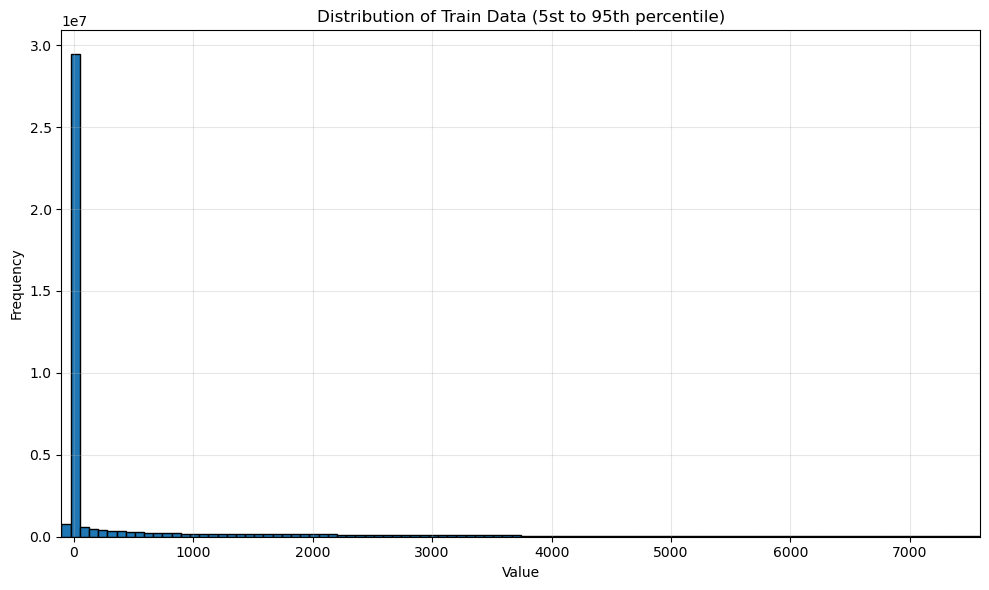

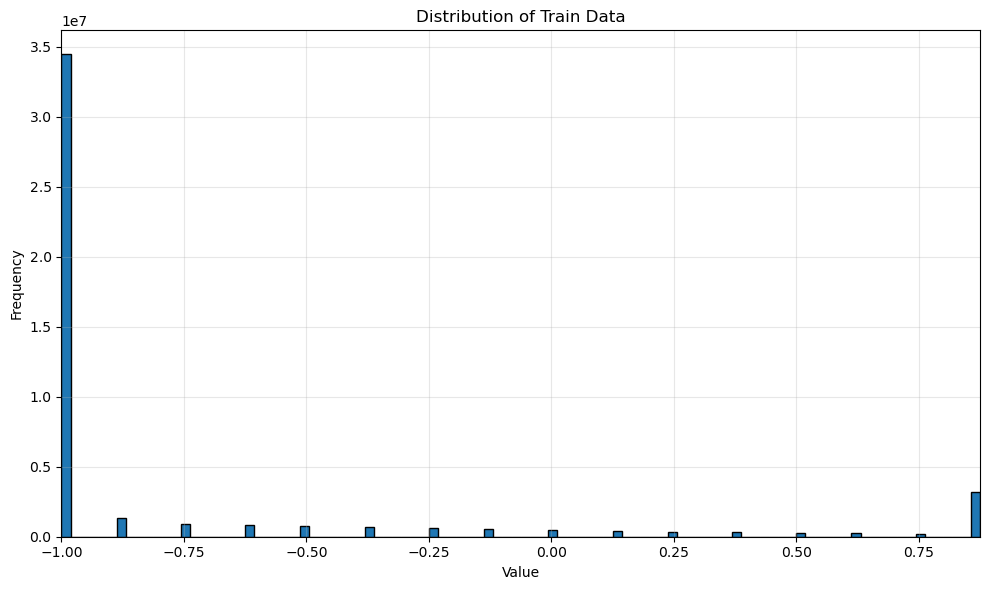

No pixels above median charge for event 47204
masked_pixel_coords 0 (0, 5, 10)
masked_pixel_charges 0 8732.2998046875
masked_pixel_coords 0 (0, 6, -1)
masked_pixel_charges 0 10437.099609375
masked_pixel_coords 0 (0, 6, 2)
masked_pixel_charges 0 0.0
Total memory: 376.23 GB
Available memory: 249.99 GB
Used memory: 114.65 GB
Memory usage percentage: 33.6%


In [19]:
data = process_dataset(input_data, target_data, HYPERPARAMETERS, global_min, global_max)

In [190]:
# Encode dataset
# encoder = load_quantized_model('best_encoder')

# data["input_train_data_encoded"] = encode_data(data["input_train_data_combined"], encoder, HYPERPARAMETERS)
# data["input_validate_data_encoded"] = encode_data(data["input_validate_data_combined"], encoder, HYPERPARAMETERS)
# data["input_test_data_encoded"] = encode_data(data["input_test_data_combined"], encoder, HYPERPARAMETERS)


# autoencoder = load_quantized_model('best_autoencoder_new')
# autoencoder = tf.keras.models.load_model('best_VAE_pruned')

data["input_train_data_recreated"] = recreate_data(data["input_train_data_combined"], model, HYPERPARAMETERS)
data["input_validate_data_recreated"] = recreate_data(data["input_validate_data_combined"], model, HYPERPARAMETERS)
data["input_test_data_recreated"] = recreate_data(data["input_test_data_combined"], model, HYPERPARAMETERS)
      

13711/13711 [==============================] - 34s 2ms/step
predictions shape is (438739, 104)
1714/1714 [==============================] - 4s 2ms/step
predictions shape is (54842, 104)
1714/1714 [==============================] - 4s 2ms/step
predictions shape is (54843, 104)
(438739, 105)


# Model Training

In [183]:
try:
    hyper_search_results = hyperparameter_search(data, HYPERPARAMETERS, param_grid, result_file=SAVE_FILE)
    send_email_notification("All done with hyperparameter search", 'Done!')
except Exception as e:
    print("Error encountered:", e)
    send_email_notification("Hyperparameter search ran into an error", 'Go fix it')

Skipping already tested hyperparameters: {'DUMMY_INDEX': 1, 'MODEL_TYPE': 'VAE', 'INPUT_MASKING': 'ALL', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Quantized', 'UNSCALING': True, 'IO_BITS': 4, 'MIN_EDGE': 0, 'MAX_EDGE': 6000, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'None', 'INCLUDE_X': False, 'DNN_LAYERS': [128, 64, 32, 16], 'ENCODER_LAYERS': [24], 'LATENT_SPACE': 8, 'DECODER_LAYERS': [24, 48, 64], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [8, 8, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 100, 'PATIENCE': 20, 'VAE_BETA_START': 5e-05, 'VAE_BETA': 0.00025, 'WARMUP_EPOCHS': 50, 'CYCLE_EPOCHS': 50, 'ADV_VAE_BETA_START': 0.001, 'ADV_VAE_BETA': 0.01, 'ADV_WARMUP_EPOCHS': 75, 'ADV_CYCLE_EPOCHS': 50, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 50, 'POST_PRUNE_EPOCHS': 50}
Testing hyperparameters: {'DUMMY_INDEX': 1, 'MODEL_TYPE': 'VAE', 'INPUT_MASKING': 'ALL', 'NUM_TIME_SLICES': 8, 'E

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
  4/429 [..............................] - ETA: 8s - loss: 0.0101 - total_loss: 0.0101 - reconstruction_loss: 0.0101 - kl_loss: 3.3461   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0191s). Check your callbacks.


429/429 [==============================] - 13s 18ms/step - loss: 0.0101 - total_loss: 0.0101 - reconstruction_loss: 0.0101 - kl_loss: 4.0777 - val_loss: 0.0117 - val_total_loss: 0.0117 - val_reconstruction_loss: 0.0117 - val_kl_loss: 4.4716
Epoch 2/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0100 - total_loss: 0.0100 - reconstruction_loss: 0.0100 - kl_loss: 4.6345 - val_loss: 0.0117 - val_total_loss: 0.0117 - val_reconstruction_loss: 0.0117 - val_kl_loss: 4.7991
Epoch 3/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0100 - total_loss: 0.0100 - reconstruction_loss: 0.0100 - kl_loss: 4.8925 - val_loss: 0.0107 - val_total_loss: 0.0107 - val_reconstruction_loss: 0.0107 - val_kl_loss: 4.9834
Epoch 4/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0100 - total_loss: 0.0100 - reconstruction_loss: 0.0100 - kl_loss: 5.0688 - val_loss: 0.0117 - val_total_loss: 0.0117 - val_reconstruction_loss: 0.0117 - val_kl_loss: 5.1840
Epoch 

INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned/assets


INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned_encoder/assets


INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned_encoder/assets


/lscratch/alexyue/tmp/ipykernel_3662727/1404426299.py:104: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(simplified_pruned_encoder, 'hyperparam_search_recent_best_VAE_pruned_encoder_simplified.h5') # .h5 is the only format that works for hls4ml synthesis


Testing hyperparameters: {'DUMMY_INDEX': 1, 'MODEL_TYPE': 'VAE', 'INPUT_MASKING': 'ALL', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Quantized', 'UNSCALING': True, 'IO_BITS': 4, 'MIN_EDGE': 0, 'MAX_EDGE': 6000, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'None', 'INCLUDE_X': False, 'DNN_LAYERS': [128, 64, 32, 16], 'ENCODER_LAYERS': [24, 12], 'LATENT_SPACE': 8, 'DECODER_LAYERS': [24, 48, 64], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [8, 8, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 100, 'PATIENCE': 20, 'VAE_BETA_START': 5e-05, 'VAE_BETA': 0.00025, 'WARMUP_EPOCHS': 50, 'CYCLE_EPOCHS': 50, 'ADV_VAE_BETA_START': 0.001, 'ADV_VAE_BETA': 0.01, 'ADV_WARMUP_EPOCHS': 75, 'ADV_CYCLE_EPOCHS': 50, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 50, 'POST_PRUNE_EPOCHS': 50}
Using default input
Model: "vae"
____________________________________________________________________________________________

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
429/429 [==============================] - 12s 19ms/step - loss: 0.0152 - total_loss: 0.0152 - reconstruction_loss: 0.0152 - kl_loss: 4.2388 - val_loss: 0.0182 - val_total_loss: 0.0182 - val_reconstruction_loss: 0.0182 - val_kl_loss: 4.5044
Epoch 2/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0152 - total_loss: 0.0152 - reconstruction_loss: 0.0152 - kl_loss: 4.6616 - val_loss: 0.0167 - val_total_loss: 0.0167 - val_reconstruction_loss: 0.0167 - val_kl_loss: 4.8433
Epoch 3/50
429/429 [==============================] - 7s 17ms/step - loss: 0.0152 - total_loss: 0.0152 - reconstruction_loss: 0.0152 - kl_loss: 4.8818 - val_loss: 0.0175 - val_total_loss: 0.0175 - val_reconstruction_loss: 0.0175 - val_kl_loss: 4.9413
Epoch 4/50
429/429 [==============================] - 7s 17ms/step - loss: 0.0151 - total_loss: 0.0151 - reconstruction_loss: 0.0151 - kl_loss: 5.0350 - val_loss: 0.0165 - val_total_loss: 0.0165 - val_reconstruction_loss: 0.0165 - val_kl_loss: 5.

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
429/429 [==============================] - 12s 19ms/step - loss: 0.0131 - total_loss: 0.0131 - reconstruction_loss: 0.0131 - kl_loss: 3.7974 - val_loss: 0.0140 - val_total_loss: 0.0140 - val_reconstruction_loss: 0.0140 - val_kl_loss: 4.0739
Epoch 2/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0131 - total_loss: 0.0131 - reconstruction_loss: 0.0131 - kl_loss: 4.2980 - val_loss: 0.0137 - val_total_loss: 0.0137 - val_reconstruction_loss: 0.0137 - val_kl_loss: 4.4309
Epoch 3/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0131 - total_loss: 0.0131 - reconstruction_loss: 0.0131 - kl_loss: 4.5373 - val_loss: 0.0140 - val_total_loss: 0.0140 - val_reconstruction_loss: 0.0140 - val_kl_loss: 4.6083
Epoch 4/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0130 - total_loss: 0.0130 - reconstruction_loss: 0.0130 - kl_loss: 4.6818 - val_loss: 0.0163 - val_total_loss: 0.0163 - val_reconstruction_loss: 0.0163 - val_kl_loss: 4.

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
429/429 [==============================] - 10s 17ms/step - loss: 0.0120 - total_loss: 0.0120 - reconstruction_loss: 0.0120 - kl_loss: 4.6193 - val_loss: 0.0134 - val_total_loss: 0.0134 - val_reconstruction_loss: 0.0134 - val_kl_loss: 5.0345
Epoch 2/50
429/429 [==============================] - 6s 15ms/step - loss: 0.0120 - total_loss: 0.0120 - reconstruction_loss: 0.0120 - kl_loss: 5.2221 - val_loss: 0.0125 - val_total_loss: 0.0125 - val_reconstruction_loss: 0.0125 - val_kl_loss: 5.3856
Epoch 3/50
429/429 [==============================] - 6s 15ms/step - loss: 0.0119 - total_loss: 0.0119 - reconstruction_loss: 0.0119 - kl_loss: 5.5158 - val_loss: 0.0133 - val_total_loss: 0.0133 - val_reconstruction_loss: 0.0133 - val_kl_loss: 5.5961
Epoch 4/50
429/429 [==============================] - 6s 15ms/step - loss: 0.0119 - total_loss: 0.0119 - reconstruction_loss: 0.0119 - kl_loss: 5.7218 - val_loss: 0.0145 - val_total_loss: 0.0145 - val_reconstruction_loss: 0.0145 - val_kl_loss: 5.

INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned/assets


INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned_encoder/assets


INFO:tensorflow:Assets written to: hyperparam_search_recent_best_VAE_pruned_encoder/assets


/lscratch/alexyue/tmp/ipykernel_3662727/1404426299.py:104: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(simplified_pruned_encoder, 'hyperparam_search_recent_best_VAE_pruned_encoder_simplified.h5') # .h5 is the only format that works for hls4ml synthesis


Testing hyperparameters: {'DUMMY_INDEX': 2, 'MODEL_TYPE': 'VAE', 'INPUT_MASKING': 'ALL', 'NUM_TIME_SLICES': 8, 'ENCODER_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Quantized', 'UNSCALING': True, 'IO_BITS': 4, 'MIN_EDGE': 0, 'MAX_EDGE': 6000, 'Y0_SCALING': 'Linear', 'ENCODING_NODES': 'None', 'INCLUDE_X': False, 'DNN_LAYERS': [128, 64, 32, 16], 'ENCODER_LAYERS': [24], 'LATENT_SPACE': 8, 'DECODER_LAYERS': [24, 48, 64], 'OUTPUT': 'SOFTMAX', 'QUANTIZATION_BITS': [8, 8, 0], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 125, 'PATIENCE': 20, 'VAE_BETA_START': 5e-05, 'VAE_BETA': 0.00025, 'WARMUP_EPOCHS': 50, 'CYCLE_EPOCHS': 50, 'ADV_VAE_BETA_START': 0.001, 'ADV_VAE_BETA': 0.01, 'ADV_WARMUP_EPOCHS': 75, 'ADV_CYCLE_EPOCHS': 50, 'FINAL_SPARSITY': 0.4, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 50, 'POST_PRUNE_EPOCHS': 50}
Using default input
Model: "vae"
________________________________________________________________________________________________

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
429/429 [==============================] - 10s 17ms/step - loss: 0.0122 - total_loss: 0.0122 - reconstruction_loss: 0.0122 - kl_loss: 4.1006 - val_loss: 0.0127 - val_total_loss: 0.0127 - val_reconstruction_loss: 0.0127 - val_kl_loss: 4.4504
Epoch 2/50
429/429 [==============================] - 6s 15ms/step - loss: 0.0121 - total_loss: 0.0121 - reconstruction_loss: 0.0121 - kl_loss: 4.6440 - val_loss: 0.0128 - val_total_loss: 0.0128 - val_reconstruction_loss: 0.0128 - val_kl_loss: 4.7776
Epoch 3/50
429/429 [==============================] - 6s 14ms/step - loss: 0.0121 - total_loss: 0.0121 - reconstruction_loss: 0.0121 - kl_loss: 4.9254 - val_loss: 0.0124 - val_total_loss: 0.0124 - val_reconstruction_loss: 0.0124 - val_kl_loss: 5.0825
Epoch 4/50
429/429 [==============================] - 6s 15ms/step - loss: 0.0121 - total_loss: 0.0121 - reconstruction_loss: 0.0121 - kl_loss: 5.1324 - val_loss: 0.0125 - val_total_loss: 0.0125 - val_reconstruction_loss: 0.0125 - val_kl_loss: 5.

Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/50
  4/429 [..............................] - ETA: 9s - loss: 0.0122 - total_loss: 0.0122 - reconstruction_loss: 0.0122 - kl_loss: 3.6764   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0216s). Check your callbacks.


429/429 [==============================] - 12s 19ms/step - loss: 0.0127 - total_loss: 0.0127 - reconstruction_loss: 0.0127 - kl_loss: 4.3985 - val_loss: 0.0137 - val_total_loss: 0.0137 - val_reconstruction_loss: 0.0137 - val_kl_loss: 4.8066
Epoch 2/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0127 - total_loss: 0.0127 - reconstruction_loss: 0.0127 - kl_loss: 4.9191 - val_loss: 0.0134 - val_total_loss: 0.0134 - val_reconstruction_loss: 0.0134 - val_kl_loss: 5.0178
Epoch 3/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0127 - total_loss: 0.0127 - reconstruction_loss: 0.0127 - kl_loss: 5.1488 - val_loss: 0.0147 - val_total_loss: 0.0147 - val_reconstruction_loss: 0.0147 - val_kl_loss: 5.2582
Epoch 4/50
429/429 [==============================] - 7s 16ms/step - loss: 0.0127 - total_loss: 0.0127 - reconstruction_loss: 0.0127 - kl_loss: 5.2929 - val_loss: 0.0138 - val_total_loss: 0.0138 - val_reconstruction_loss: 0.0138 - val_kl_loss: 5.3564
Epoch 

KeyboardInterrupt: 

In [193]:
model, train_metrics = train_model(data, HYPERPARAMETERS)
# display_vae_metrics(data, model, HYPERPARAMETERS)
# plotMSEDistribution(data, model, HYPERPARAMETERS, unscaling=True)
# test_results = test_autoencoder(data, model, HYPERPARAMETERS)
# print(test_results)

(438739, 105)
(54842, 105)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 128)               13568     
                                                                 
 batch_norm1 (BatchNormaliz  (None, 128)               512       
 ation)                                                          
                                                                 
 relu1 (QActivation)         (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 64)                8256      
                                                                 
 batch_norm2 (BatchNormaliz  (None, 64)                256       
 ation)                         

In [14]:
# VAEGAN Usage
ENCODER_TIME_SLICES = HYPERPARAMETERS["ENCODER_TIME_SLICES"]
vaegan = qVAEGANmodel(HYPERPARAMETERS)
full_data = data["input_train_data_combined"]
partial_data =  np.concatenate([full_data[:, :ENCODER_TIME_SLICES*13], full_data[:, -1:]], axis=1)
train_vaegan(vaegan, partial_data, full_data, HYPERPARAMETERS)
display_vae_metrics(data, vaegan, HYPERPARAMETERS)
plotMSEDistribution(data, vaegan, HYPERPARAMETERS)
test_results = test_autoencoder(data, vaegan, HYPERPARAMETERS)
print(test_results)


Epoch 1/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0227, KL loss: 2.8464, Adversarial loss: 2.7634, Discriminator loss: 0.2596

Epoch 2/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0162, KL loss: 3.2028, Adversarial loss: 2.8306, Discriminator loss: 0.2725

Epoch 3/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0107, KL loss: 3.7465, Adversarial loss: 3.0484, Discriminator loss: 0.4319

Epoch 4/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0089, KL loss: 4.2056, Adversarial loss: 3.4897, Discriminator loss: 0.3257

Epoch 5/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0059, KL loss: 4.5086, Adversarial loss: 1.6582, Discriminator loss: 0.8045

Epoch 6/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0057, KL loss: 4.6162, Adversarial loss: 2.0020, Discriminator loss: 0.5391

Epoch 7/300. Beta = 5e-05. Adv_Beta = 0.001
Reconstruction loss: 0.0057, KL loss: 4.6599, Adversarial loss: 1.7107, Discriminator loss:

#  Model Read / Write

In [186]:
# Save the model when done  
# model.save(f'./best_post_VAE_classifier.h5')
tf.keras.models.save_model(model, 'best_4bit_VAE', save_format='tf')
tf.keras.models.save_model(model.encoder, 'best_4bit_VAE_encoder', save_format='tf')
# run cp hyperparam_search_recent_best_VAE_pruned_encoder_simplified.h5 best_4bit_VAE_encoder_simplfied.h5

# tf.keras.models.save_model(vaegan, 'best_VAEGAN', save_format='tf')
# tf.keras.models.save_model(vaegan.encoder, 'best_VAEGAN_encoder', save_format='tf')
# tf.keras.models.save_model(vaegan.decoder, 'best_VAEGAN_decoder', save_format='tf')
# tf.keras.models.save_model(vaegan.discriminator, 'best_VAEGAN_discriminator', save_format='tf')

INFO:tensorflow:Assets written to: best_4bit_VAE/assets


INFO:tensorflow:Assets written to: best_4bit_VAE/assets


INFO:tensorflow:Assets written to: best_4bit_VAE_encoder/assets


INFO:tensorflow:Assets written to: best_4bit_VAE_encoder/assets


In [16]:
# Load in a model
# model = load_quantized_model('best_on_chip_classifier')
# model = load_quantized_model('4_slice_L2_S24_best_performance')
# model = load_quantized_model('AE_12_8_24_48_log_scaling_1_to_8_best_performance_10_10_2')
# model = load_quantized_model('4_slice_L2_S24_best_performance')
# model = load_quantized_model('hyperparam_search_recent_best')
model = tf.keras.models.load_model('best_4bit_VAE')
model.encoder = tf.keras.models.load_model('best_4bit_VAE_encoder')
pruned_encoder_simplified = load_quantized_model('best_4bit_VAE_encoder_simplfiied')

# model = tf.keras.models.load_model('hyperparam_search_recent_best_VAE_pruned')
# model.encoder = tf.keras.models.load_model('hyperparam_search_recent_best_VAE_pruned_encoder')
# pruned_encoder_simplified = load_quantized_model('hyperparam_search_recent_best_VAE_pruned_encoder_simplified')


model.encoder.summary()
print(f"sparsity of encoder {calculate_sparsity(model.encoder)}")
pruned_encoder_simplified.summary()
print(f"sparsity of pruned_encoder_simplified {calculate_sparsity(pruned_encoder_simplified)}")

# vaegan = tf.keras.models.load_model('best_VAEGAN')
# vaegan.encoder = tf.keras.models.load_model('best_VAEGAN_encoder')
# vaegan.decoder = tf.keras.models.load_model('best_VAEGAN_decoder')
# vaegan.discriminator = tf.keras.models.load_model('best_VAEGAN_discriminator')


Model: "simplified_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 partial_input (InputLayer)  [(None, 53)]              0         
                                                                 
 flatten_input (Flatten)     (None, 53)                0         
                                                                 
 dense1 (QDense)             (None, 24)                1296      
                                                                 
 relu1 (QActivation)         (None, 24)                0         
                                                                 
 batch_norm1 (BatchNormaliz  (None, 24)                96        
 ation)                                                          
                                                                 
 z_mean (QDense)             (None, 8)                 200       
                                                

In [74]:
def create_simplified_encoder(original_encoder):
    input_layer = original_encoder.get_layer('partial_input').input

    x = input_layer
    for layer in original_encoder.layers[1:]: 
        if layer.name == 'z_mean':
            z_mean = layer(x)
            break
        elif layer.name not in ['z_log_var', 'sampling_4']:
            x = layer(x)
    
    simplified_encoder = Model(inputs=input_layer, outputs=z_mean, name="simplified_encoder")
    
    return simplified_encoder

original_encoder = pruned_vae.encoder 
simplified_encoder = create_simplified_encoder(original_encoder)

simplified_encoder.summary()

tf.keras.models.save_model(simplified_encoder, 'best_VAE_encoder_pruned_simplified.h5') # .h5 is the only format that works for hls4ml synthesis

Model: "simplified_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 partial_input (InputLayer)  [(None, 53)]              0         
                                                                 
 flatten_input (Flatten)     (None, 53)                0         
                                                                 
 dense1 (QDense)             (None, 24)                1296      
                                                                 
 relu1 (QActivation)         (None, 24)                0         
                                                                 
 batch_norm1 (BatchNormaliz  (None, 24)                96        
 ation)                                                          
                                                                 
 z_mean (QDense)             (None, 8)                 200       
                                                

/lscratch/alexyue/tmp/ipykernel_81240/1993864851.py:21: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(simplified_encoder, 'best_VAE_encoder_pruned_simplified.h5') # .h5 is the only format that works for hls4ml synthesis


In [71]:
def calculate_sparsity(model):
    non_zero = total = 0
    for layer in model.layers:
        if isinstance(layer, QDense):
            weight = layer.get_weights()[0]
            non_zero += np.count_nonzero(weight)
            total += weight.size
    return 1 - (non_zero / total) if total > 0 else 0

def apply_pruning_to_dense(layer, **kwargs):
    if isinstance(layer, QDense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **kwargs)
    return layer

class PrintSparsityCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch} sparsity: {calculate_sparsity(self.model.encoder)}")

def prune_vae_encoder(vae, data, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]

    print(f"Initial encoder sparsity: {calculate_sparsity(vae.encoder)}")
    
    input_train_data_combined = data["input_train_data_combined"]
    input_validate_data_combined = data["input_validate_data_combined"]
    input_train_data_combined_truncated = np.concatenate([input_train_data_combined[:, :ENCODER_TIME_SLICES*13], input_train_data_combined[:, -1:]], axis=1)
    input_validate_data_combined_truncated = np.concatenate([input_validate_data_combined[:, :ENCODER_TIME_SLICES*13], input_validate_data_combined[:, -1:]], axis=1)
    
    steps_per_epoch = input_train_data_combined.shape[0] // BATCH_SIZE
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch
        )
    }
   
    # Prune only the encoder
    pruned_encoder = tf.keras.models.clone_model(
        vae.encoder,
        clone_function=lambda layer: apply_pruning_to_dense(layer, **pruning_params)
    )

    # Create a new VAE with the pruned encoder
    vae_layer = vae.get_layer('vae_layer')
    pruned_vae_layer = VAELayer(pruned_encoder, vae_layer.decoder, name="pruned_vae_layer")
    
    partial_input = vae.inputs[0]
    full_input = vae.inputs[1]
    pruned_vae_outputs = pruned_vae_layer([partial_input, full_input])
    pruned_vae = Model(inputs=[partial_input, full_input], outputs=pruned_vae_outputs, name="pruned_vae")

    # Set beta and encoder properties
    pruned_vae.beta = vae.beta
    pruned_vae.encoder = pruned_encoder

    # Compile the pruned model
    pruned_vae.compile(optimizer=vae.optimizer)

    # Create pruning callbacks
    callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir="logs"),
        PrintSparsityCallback()
    ]

    # Fine-tune the pruned model
    pruned_vae.fit(
        [input_train_data_combined_truncated, input_train_data_combined], 
        input_train_data_combined,
        validation_data=([input_validate_data_combined_truncated, input_validate_data_combined], input_validate_data_combined),  
        epochs=NUM_PRUNE_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )

    # Apply final mask to the encoder
    pruned_vae.encoder = tfmot.sparsity.keras.strip_pruning(pruned_vae.encoder)
    print(f"Final encoder sparsity: {calculate_sparsity(pruned_vae.encoder)}")
    
    return pruned_vae

# Usage
original_vae = model
pruned_vae = prune_vae_encoder(original_vae, data, HYPERPARAMETERS)

Initial encoder sparsity: 0.0
Layer VAELayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/20
429/429 [==============================] - 12s 18ms/step - loss: 0.0040 - total_loss: 0.0040 - reconstruction_loss: 0.0040 - kl_loss: 4.7025 - val_loss: 0.0040 - val_total_loss: 0.0040 - val_reconstruction_loss: 0.0040 - val_kl_loss: 5.0893
Epoch 2/20
429/429 [==============================] - 7s 15ms/step - loss: 0.0039 - total_loss: 0.0039 - reconstruction_loss: 0.0039 - kl_loss: 5.3125

In [ ]:
# Save the pruned encoder
pruned_vae.encoder.save('best_VAE_encoder_pruned.h5')

In [15]:
# Seperate and save an encoder from an autoencoder
# autoencoder = load_quantized_model('best_autoencoder_new')
# encoder_model = extract_encoder(autoencoder)
# encoder_model.summary()
# encoder_model.save(f'./best_encoder_new.h5')

# Display Model Performance

1714/1714 [==============================] - 4s 2ms/step
predictions [[7.4116838e-01 2.0008293e-01 5.8748644e-02]
 [1.9645840e-02 9.7954971e-01 8.0438005e-04]
 [5.5069840e-01 3.9761212e-01 5.1689409e-02]
 [6.5801638e-01 9.6706502e-02 2.4527711e-01]
 [6.8841106e-01 7.6233119e-02 2.3535573e-01]
 [6.7180812e-01 1.8391170e-01 1.4428020e-01]
 [6.8197209e-01 2.4344261e-01 7.4585311e-02]
 [6.0640621e-01 7.5734913e-02 3.1785884e-01]
 [6.6649175e-01 2.0494053e-01 1.2856764e-01]
 [7.5800395e-01 4.9255978e-02 1.9273998e-01]]
[(0.8731637798728349, 0.29886814426611347), (0.9001680917927355, 0.2609091239946137), (0.9301322809325441, 0.2123230338100957), (0.959840678213842, 0.15714961604250827), (0.9801213184243222, 0.10612512283000328), (0.990097200906234, 0.0759180405429996), (0.9949937879120077, 0.051825162863485826), (0.9989402908718849, 0.018961313098227607)]


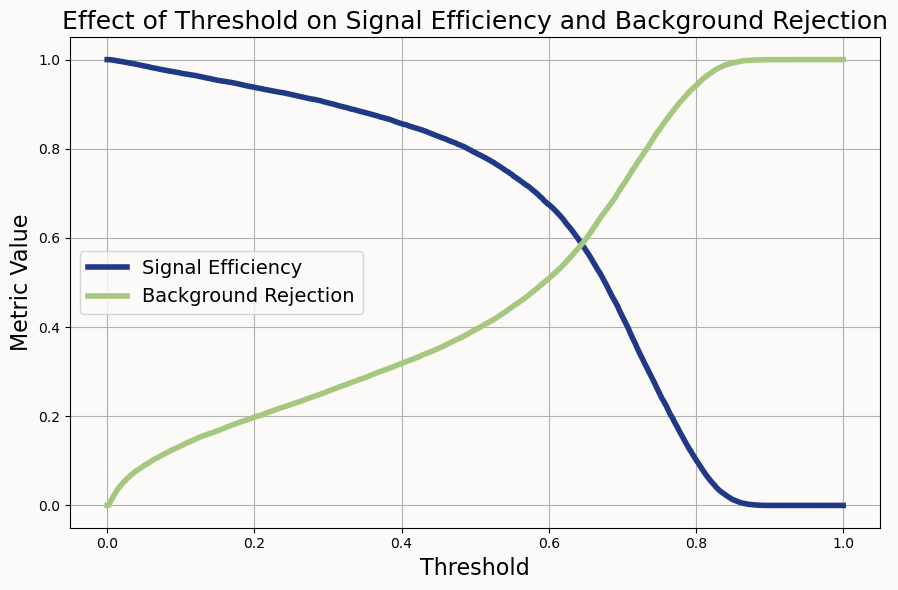

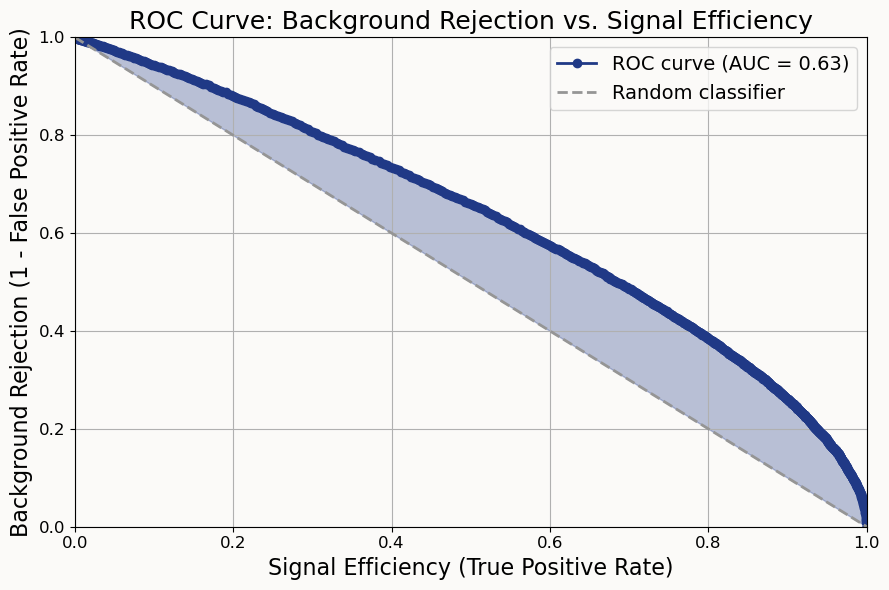

In [194]:
results = displayPerformance(data, model, HYPERPARAMETERS, bins = np.arange(0, 0.04, 0.0002))

1714/1714 [==============================] - 3s 2ms/step


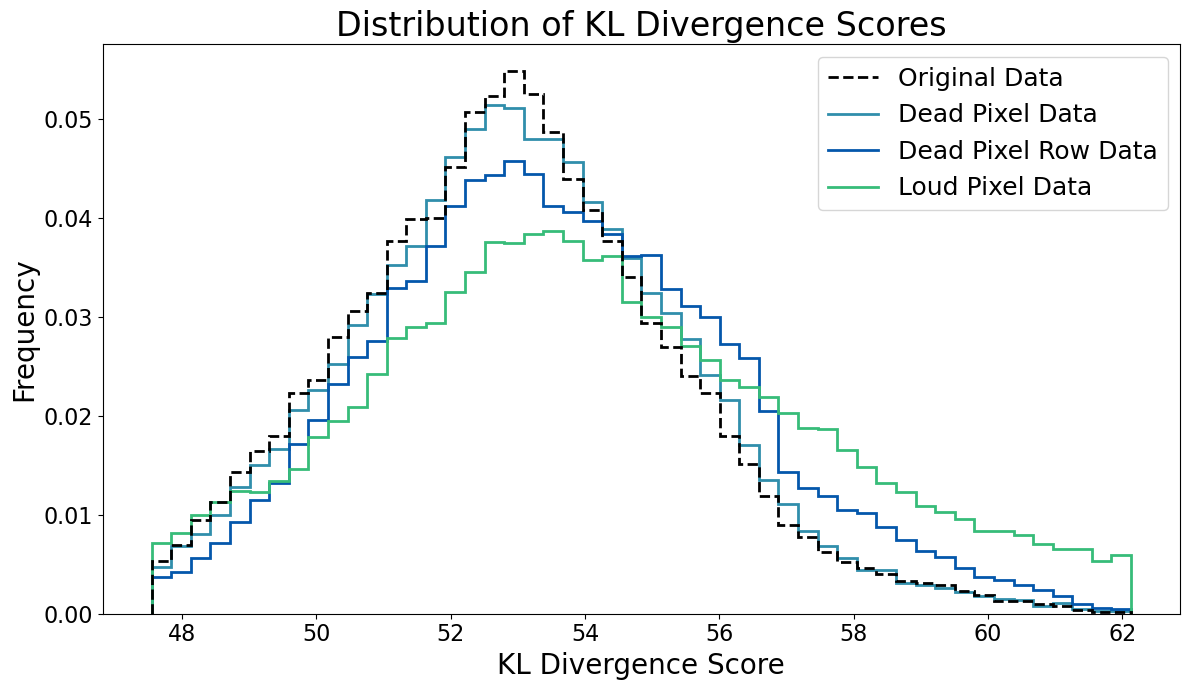

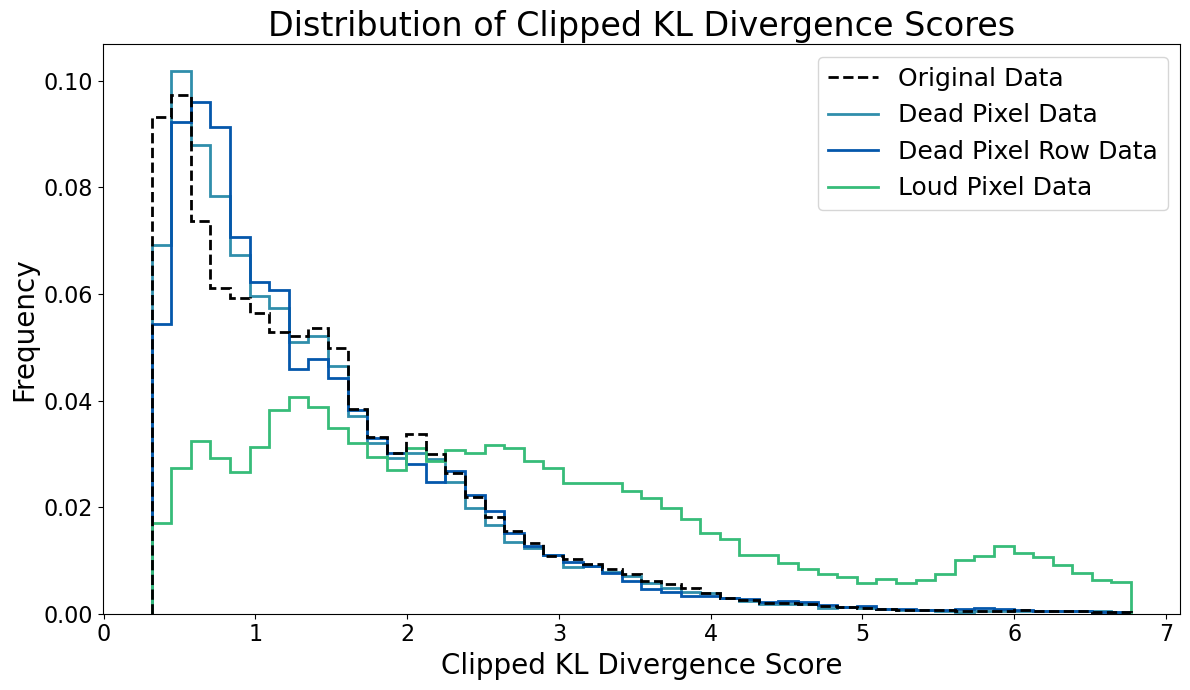

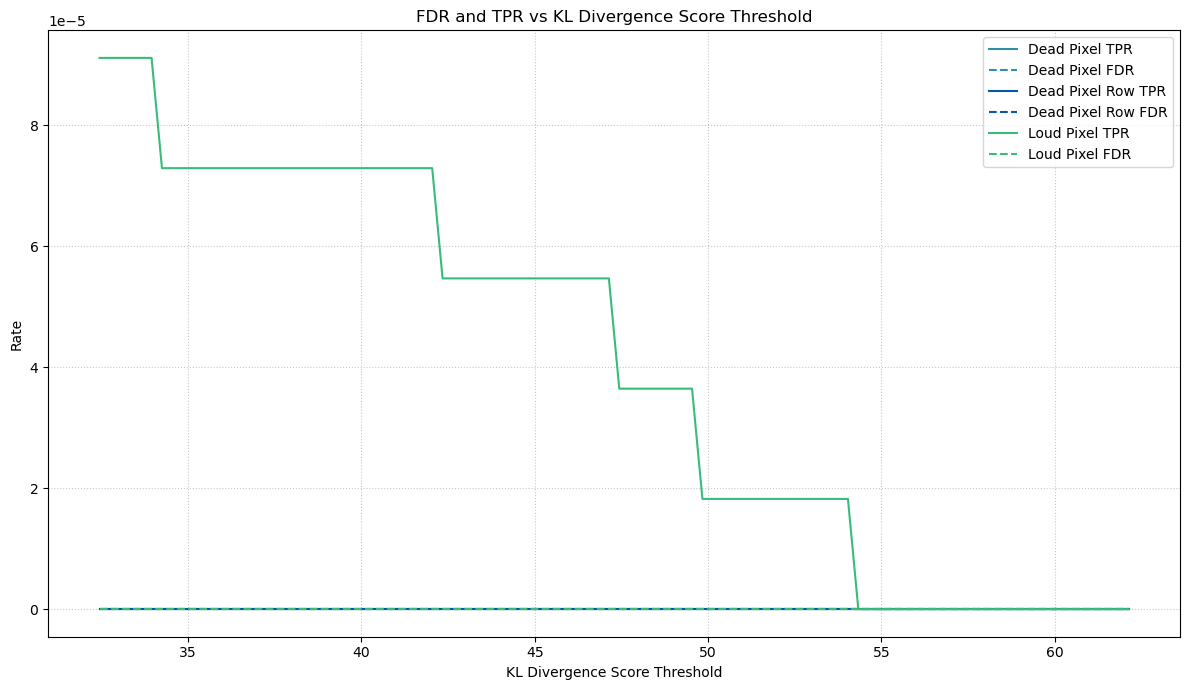

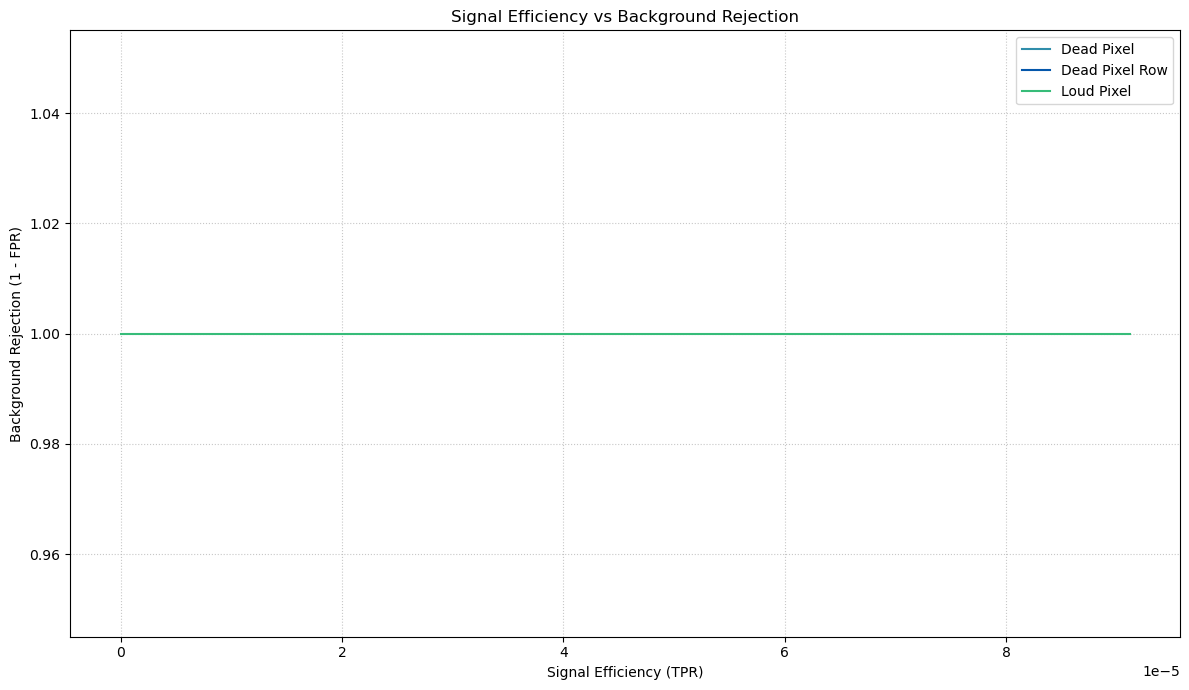


False Discovery Rate at 1.00% False Positive Rate:
Dead Pixel: 52.00% (at FPR = 1.00%)
Dead Pixel Row: 46.95% (at FPR = 1.00%)
Loud Pixel: 7.18% (at FPR = 1.00%)
1714/1714 [==============================] - 5s 3ms/step
total quantized bit errors [1.625 1.75  3.    2.625 1.25  3.375 0.125 1.375 3.125 1.125 2.125 2.125
 2.75  2.125 1.125 3.5   2.    1.875 2.5  ]
total_bit_errors_per_sample [13. 14. 24. 21. 10. 27.  1. 11. 25.  9. 17. 17. 22. 17.  9. 28. 16. 15.
 20.]
input_test_data_combined shape (54843, 105)
mean total error 0.11066001831565708
median total error 0.10027689245975378


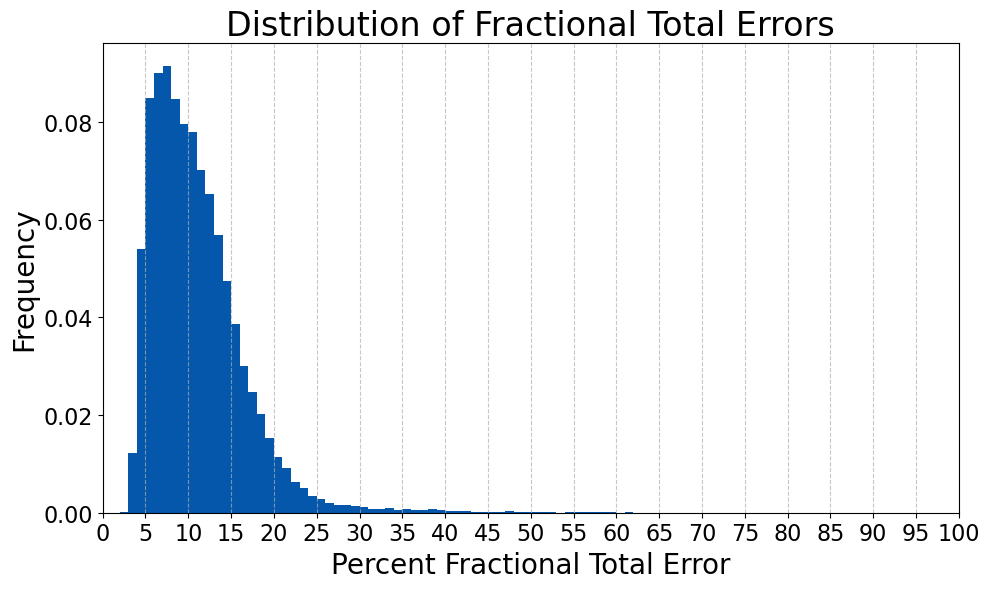

mean total error 18.433090822894446
median total error 13.0


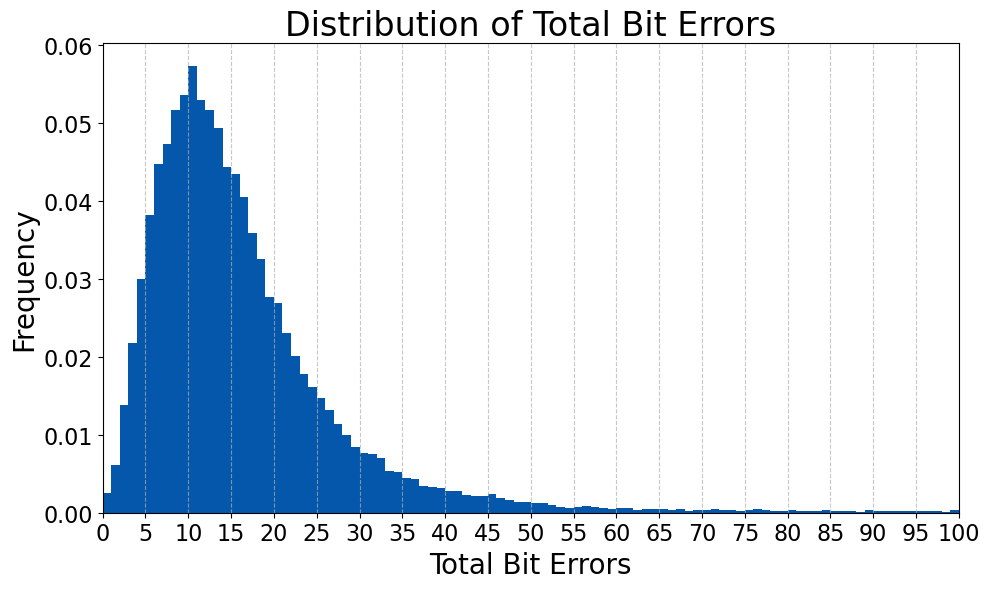

1714/1714 [==============================] - 3s 1ms/step
{'mean_mse': 0.009238641003095443, 'median_mse': 0.002712516538355948, 'dead_pixel_tpr_at_fpr': '(0.1000, 0.1109), (0.0500, 0.0524), (0.0100, 0.0105)', 'dead_pixel_row_tpr_at_fpr': '(0.1000, 0.1818), (0.0500, 0.1004), (0.0100, 0.0222)', 'loud_pixel_tpr_at_fpr': '(0.1000, 0.2889), (0.0500, 0.2124), (0.0100, 0.0946)'}


In [187]:
display_vae_metrics(data, model, HYPERPARAMETERS)
plotMSEDistribution(data, model, HYPERPARAMETERS, unscaling=True)
test_results = test_autoencoder(data, model, HYPERPARAMETERS)
print(test_results)

In [83]:
# display_vae_metrics(data, pruned_vae, HYPERPARAMETERS)
# plotMSEDistribution(data, pruned_vae, HYPERPARAMETERS)
# test_results = test_autoencoder(data, pruned_vae, HYPERPARAMETERS)
# print(test_results)

# Dataset Display

target datapoint  [1. 0. 0.]
input_datapoint_reshaped shape (1, 105)
input_datapoint_truncated shape (1, 53)
1/1 [==============================] - 0s 24ms/step


total_errors 4875.0 and total_charge 118875.0 so total_fractional_error 0.04100946372239748
in bits: total_errors 39000.0 and total_charge 951000.0 so total_fractional_error 0.04100946372239748
data point 513
input_datapoint shape (104,)
input_datapoint_truncated_grid shape (4, 13)


ValueError: Number of samples, -681, must be non-negative.

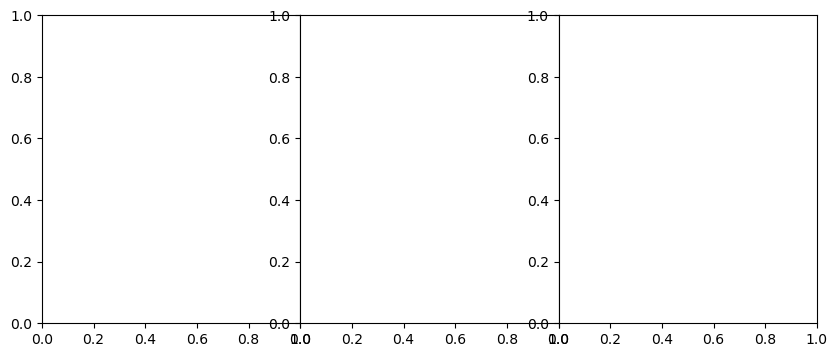

In [23]:
# DATASET DISPLAY
# rand_idx = random.randint(0, 999)
# print(rand_idx)
input_data_example = data["input_data_example"]
target_data_example = data["target_data_example"]
# animation, gif = display_dataset(input_data_example, target_data_example, rand_idx, gif=False, difference=False)

# 929
# while True:
rand_idx = random.randint(0, 999) # 746
# simple_display_dataset(data, rand_idx)
total_fractional_error = display_model_example(model, data, HYPERPARAMETERS, rand_idx, global_min, global_max,
                unscaling=True, masking=False, rounding=True)
    # if (total_fractional_error > 0.13 and total_fractional_error < 0.16):
    #     break

In [150]:
anomalies, kl_scores, clipped_kl_scores, threshold = detect_anomalies_by_kld(model, data["input_test_data_combined"], hyperparams, 99)

NameError: name 'hyperparams' is not defined

In [33]:
# ANOMALY DISPLAY
input_test_data_combined = data["input_test_data_combined"]
anomaly_indices = [i for i, is_anomaly in enumerate(anomalies) if is_anomaly]

for i in range(10):
    rand_idx = random.choice(anomaly_indices)
    print("kl score is ", kl_scores[rand_idx])
    print("clipped_kl_scores is ", clipped_kl_scores[rand_idx])
    display_model_example(model, data, HYPERPARAMETERS, rand_idx, global_min, global_max,
                         unscaling=True, masking=False)
    # animation, gif = display_dataset(input_data_example, target_data_example, rand_idx, gif=False, difference=False)

NameError: name 'anomalies' is not defined

In [26]:


def show_autoencoder_dataset(data, model, hyperparams, i, num_frames, gif=False):
    ENCODER_TIME_SLICES = hyperparams["ENCODER_TIME_SLICES"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    LATENT_SPACE = hyperparams["LATENT_SPACE"]
    
    # Get the datasets
    input_data_example = data["input_data_example"]
    target_data_example = data["target_data_example"]
    input_dataset_combined = data["input_test_data_combined"]
    target_dataset_coded = data["target_test_data_coded"]

    # Get predictions
    all_z_mean, all_z_log_var, all_z = model.encoder.predict(input_dataset_combined)
    all_predictions = model.predict(input_dataset_combined)
    all_kld_scores = -0.5 * np.sum(1 + all_z_log_var - np.square(all_z_mean) - np.exp(all_z_log_var), axis=1)
    kld_threshold = np.percentile(all_kld_scores, 95)
    print(f"kld_threshold is {kld_threshold}")

    # Create figure
    fig = plt.figure(figsize=(16, 12))  # Adjusted figure height
    
    # Define subplot positions
    positions = [
        [0.05, 0.74, 0.22, 0.2],    # Top row, first plot
        [0.29, 0.74, 0.22, 0.2],    # Top row, second plot
        [0.53, 0.74, 0.22, 0.2],    # Top row, third plot
        [0.77, 0.74, 0.22, 0.2],    # Top row, fourth plot
        [0.05, 0.48, 0.46, 0.2],    # Second row, first plot (double width)
        [0.53, 0.48, 0.46, 0.2],    # Second row, second plot (double width)
    ]
    
    # Create subplots
    axes = [fig.add_axes(pos) for pos in positions]
    
    custom_cmap = create_custom_colormap()
    final_time_slice = 20

    # Function to create the top three heatmaps
    def create_heatmap(ax, data, title):
        im = ax.imshow(data.T, cmap=custom_cmap, vmin=-5000, vmax=40000)
        ax.invert_yaxis()
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_xlabel("Time Slice")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        return im

    # Initialize plots
    im0 = create_heatmap(axes[0], np.zeros((ENCODER_TIME_SLICES, 13)), "Input")
    im1 = create_heatmap(axes[1], np.zeros((NUM_TIME_SLICES, 13)), "Output")
    im2 = create_heatmap(axes[2], np.zeros((NUM_TIME_SLICES, 13)), "Target")
    im3 = create_heatmap(axes[3], np.zeros((NUM_TIME_SLICES, 13)), "Target")
    
    # Set up the bottom left plot (previously the main plot)
    ax_main = axes[4]
    im4 = ax_main.imshow(np.zeros((13, 21)), cmap=custom_cmap, vmin=-5000, vmax=40000)
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(13))
    ax_main.set_xticks(np.arange(21))
    ax_main.grid(True, color='gray', alpha=0.7)
    ax_main.set_title("Final Pixel Charge Depositions")

    # Set up the KLD histogram
    ax_kld = axes[5]  # Use the last axis for the KLD histogram
    ax_kld.set_title(f"KL Divergence Scores Distribution")
    ax_kld.set_xlabel("KLD Score")
    ax_kld.set_ylabel("Probability Density")

    # Set up the static (blue) histogram for all data
    bins = np.linspace(4, 25, 50 + 1)
    hist_all, bins_all = np.histogram(all_kld_scores, bins=bins, density=True)
    ax_kld.bar(bins_all[:-1], hist_all, width=(bins_all[1]-bins_all[0]), alpha=0.5, color='blue', label='All Data')
    
    # Set up the dynamic (green) histogram
    hist, _ = np.histogram([], bins=bins_all, density=True)  # Use the same bins as the full dataset
    bar_container = ax_kld.bar(bins_all[:-1], hist, width=(bins_all[1]-bins_all[0]), alpha=0.5, color='green', label='Current Data')

    ax_kld.legend()
    ax_kld.set_ylim(0, max(hist_all) * 1.1)  # Set initial y-axis limit based on full dataset
    
    # Add color bar
    # cbar = fig.colorbar(im4, ax=ax_main)
    # cbar.set_label('Value')

    # Set up the latent space visualizations
    latent_axes = []
    for row in range(2):
        for col in range(4):
            ax = fig.add_axes([0.05 + col*0.19, 0.05 + row*0.20, 0.17, 0.17])
            latent_axes.append(ax)
            ax.set_xlim(-3, 3)
            ax.set_ylim(0, 1)
            if row == 0:
                ax.set_xticklabels([])
            if col > 0:
                ax.set_yticklabels([])

            

    # Create a colormap for the latent space
    cmap = plt.get_cmap('tab10')

    gaussian_curves = []
    sampled_points = []
    for n, ax in enumerate(latent_axes):
        color = cmap(n)
        curve, = ax.plot([], [], '-', color=color, alpha=0.7, linewidth=2)
        point, = ax.plot([], [], '-', color=color, linewidth=2)
        gaussian_curves.append(curve)
        sampled_points.append(point)
        
        # Add legend to each plot
        ax.legend([f'Dim {n+1}'], loc='upper right', fontsize=8)
    

    # Function to update the animation
    def update(t):
        new_idx = i + (100*t)
        # Get data for current frame
        input_datapoint = input_data_example[new_idx]
        target_datapoint = target_data_example[new_idx]
        input_datapoint_combined = input_dataset_combined[new_idx]
        target_datapoint_coded = target_dataset_coded[new_idx]

        # Process data
        # input_datapoint_reshaped = np.expand_dims(input_datapoint_combined, axis=0)
        # input_datapoint_truncated = np.concatenate([input_datapoint_reshaped[:, :ENCODER_TIME_SLICES*13], input_datapoint_reshaped[:, -1:]], axis=1)

        # Get predictions and encodings from model
        z_mean = all_z_mean[new_idx]
        z_log_var = all_z_log_var[new_idx]
        z = all_z[new_idx]
        kld = all_kld_scores[new_idx]
        predictions_reshaped = all_predictions[new_idx]


        # Separate y_0 from the datapoints
        input_y0 = input_datapoint_combined[-1]
        input_datapoint_combined = input_datapoint_combined[:-1]
        predictions_y0 = predictions_reshaped[-1]
        predictions_reshaped = predictions_reshaped[:-1]

        # Undo the transformations
        input_datapoint_combined = np.sqrt(np.abs(input_datapoint_combined)) * np.sign(input_datapoint_combined)
        predictions_reshaped = np.sqrt(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
        max_abs = np.max([np.log(np.abs(global_max)), np.log(np.abs(global_min))])
        input_datapoint_combined = input_datapoint_combined * max_abs
        predictions_reshaped = predictions_reshaped * max_abs
        input_datapoint_combined = np.exp(np.abs(input_datapoint_combined)) * np.sign(input_datapoint_combined)
        predictions_reshaped = np.exp(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
        input_y0 = input_y0 * 8
        predictions_y0 = predictions_y0 * 8

        # Reshape datapoints into grid
        input_datapoint_truncated_grid = input_datapoint_combined[:ENCODER_TIME_SLICES*13].reshape(ENCODER_TIME_SLICES, 13)
        predictions_datapoint_grid = predictions_reshaped.reshape(NUM_TIME_SLICES, 13)
        input_datapoint_grid = input_datapoint_combined.reshape(NUM_TIME_SLICES, 13)
        difference_datapoint_grid = input_datapoint_grid - predictions_datapoint_grid

        # Update heatmaps
        im0.set_data(input_datapoint_truncated_grid.T)
        im1.set_data(predictions_datapoint_grid.T)
        im2.set_data(input_datapoint_grid.T)
        im3.set_data(difference_datapoint_grid.T)
        axes[0].set_title(f"Input. y0={input_y0:.4f}")
        axes[1].set_title(f"Output. y0={predictions_y0:.4f}")
        axes[2].set_title(f"Target. y0={input_y0:.4f}")
        axes[3].set_title(f"Difference. y0={input_y0 - predictions_y0:.4f}")

        # Update main plot
        input_datapoint_copy = np.copy(input_datapoint)
        data = input_datapoint_copy[final_time_slice-1, :, :]
        im4.set_data(data)

        if kld > kld_threshold:
            axes[4].set_title(f"ANOMALY DETECTED", color="red")
        else:
            axes[4].set_title(f"")
        
        # Update labels and grid for the main plot
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update KLD histogram
        current_kld_scores = all_kld_scores[0:new_idx+1]
        hist, _ = np.histogram(current_kld_scores, bins=bins_all, density=True)
        for count, rect in zip(hist, bar_container):
            rect.set_height(count)

        # Update latent space visualizations
        x = np.linspace(-3, 3, 100)
        for j in range(LATENT_SPACE):
            mean = z_mean[j]
            std = np.exp(0.5 * z_log_var[j])
            y = norm.pdf(x, mean, std)
            gaussian_curves[j].set_data(x, y)
            
            # Calculate the height of the vertical line
            sampled_z = z[j]
            sampled_y = norm.pdf(sampled_z, mean, std)
            
            # Update the vertical line
            sampled_points[j].set_data([sampled_z, sampled_z], [0, sampled_y])
            

        fig.suptitle(f"Autoencoder Visualization (Data Point: {new_idx})", y=0.98)
        
        # Update title for the entire figure
        pt = target_datapoint[8]
        fig.suptitle(f"Data Point: {new_idx} | pt: {pt:.2f} GeV | kld: {kld:05.2f}", y=0.98)

    ani = FuncAnimation(fig, update, frames=num_frames, repeat=True)
    
    gif_path = f"data.gif"
    if gif:
        # Save the animation as a GIF
        writer = PillowWriter(fps=4)
        ani.save(gif_path, writer=writer)
    
    plt.close()
    return display(HTML(ani.to_jshtml())), gif_path

# Example usage
show_autoencoder_dataset(data, model, HYPERPARAMETERS, 0, 40, gif=True)

InvalidArgumentError: Graph execution error:

Detected at node 'BiasAdd' defined at (most recent call last):
Node: 'BiasAdd'
Matrix size-incompatible: In[0]: [32,105], In[1]: [53,24]
	 [[{{node BiasAdd}}]] [Op:__inference_predict_function_620508]

# Anomaly Detection

In [22]:
# Calculate the latent stats and anomaly scores
z_mean, z_log_var = calculate_latent_stats(data["input_test_data_encoded"])
sample_anomaly_scores = calculate_anomaly_scores(data["input_test_data_encoded"])
print(f"z_mean is {z_mean} and z_log_var is {z_log_var}")

# Call the plotting functions
plot_latent_space_boxplots(data["input_test_data_encoded"], z_mean, z_log_var, HYPERPARAMETERS)
plot_anomaly_scores(sample_anomaly_scores)
compare_anomaly_scores(results, sample_anomaly_scores)

# # Calculate the latent stats and anomaly scores
# z_mean, z_log_var = calculate_latent_stats(data["input_test_data_masked"])
# sample_anomaly_scores = calculate_anomaly_scores(data["input_test_data_masked"])
# print(f"z_mean is {z_mean} and z_log_var is {z_log_var}")

# # Call the plotting functions
# plot_latent_space_boxplots(data["input_test_data_masked"], z_mean, z_log_var, HYPERPARAMETERS)
# plot_anomaly_scores(sample_anomaly_scores)
# compare_anomaly_scores(results, sample_anomaly_scores)

KeyError: 'input_test_data_encoded'

# Dataset Saving

In [ ]:
# Write input data to file for HLS 
with open('DNN_hp_input_features.dat', 'w') as file:
    for row in input_train_data_combined:
        line = ' '.join(map(str, row))  # Convert each number to string and join with space
        file.write(line + '\n')
# Write target data to file
with open('./DNN_hp_predictions_small.dat', 'w') as file:
    for score in target_test_data_coded:
        file.write(str(score[0]) + '\n')  # Convert number to string

In [69]:
# Write to file
def write_inputs_to_file(data, file_path):
    with open(file_path, 'w') as file:
        for row in data:
            line = ' '.join(map(str, row))  # Convert each number to string and join with space
            file.write(line + '\n')
        
def write_outputs_to_file(data, file_path):
    with open(file_path, 'w') as file:
        if isinstance(data, np.ndarray):
            if data.ndim == 1:
                # Case: 1D numpy array
                for value in data:
                    file.write(f"{value}\n")
            elif data.ndim == 2:
                # Case: 2D numpy array
                np.savetxt(file, data, fmt='%g', delimiter=' ')
            else:
                raise ValueError("Numpy array must be 1D or 2D.")
        else:
            raise ValueError("Data must be a numpy array.")
        
write_inputs_to_file(data["input_test_data_combined"], './log_1_slice_test_inputs.dat')
write_outputs_to_file(data["target_test_data_coded"], './log_single1_test_outputs.dat')